In [1]:
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
import graphviz
from sklearn import tree
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px
import plotly.colors as pc
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing
# 1. Data cleaning

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Advance Project/hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015/7/1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015/7/1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015/7/2
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015/7/2
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015/7/3


In [4]:
df.shape

(119390, 32)

In [5]:
# Check missing values in the data.
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

<Axes: >

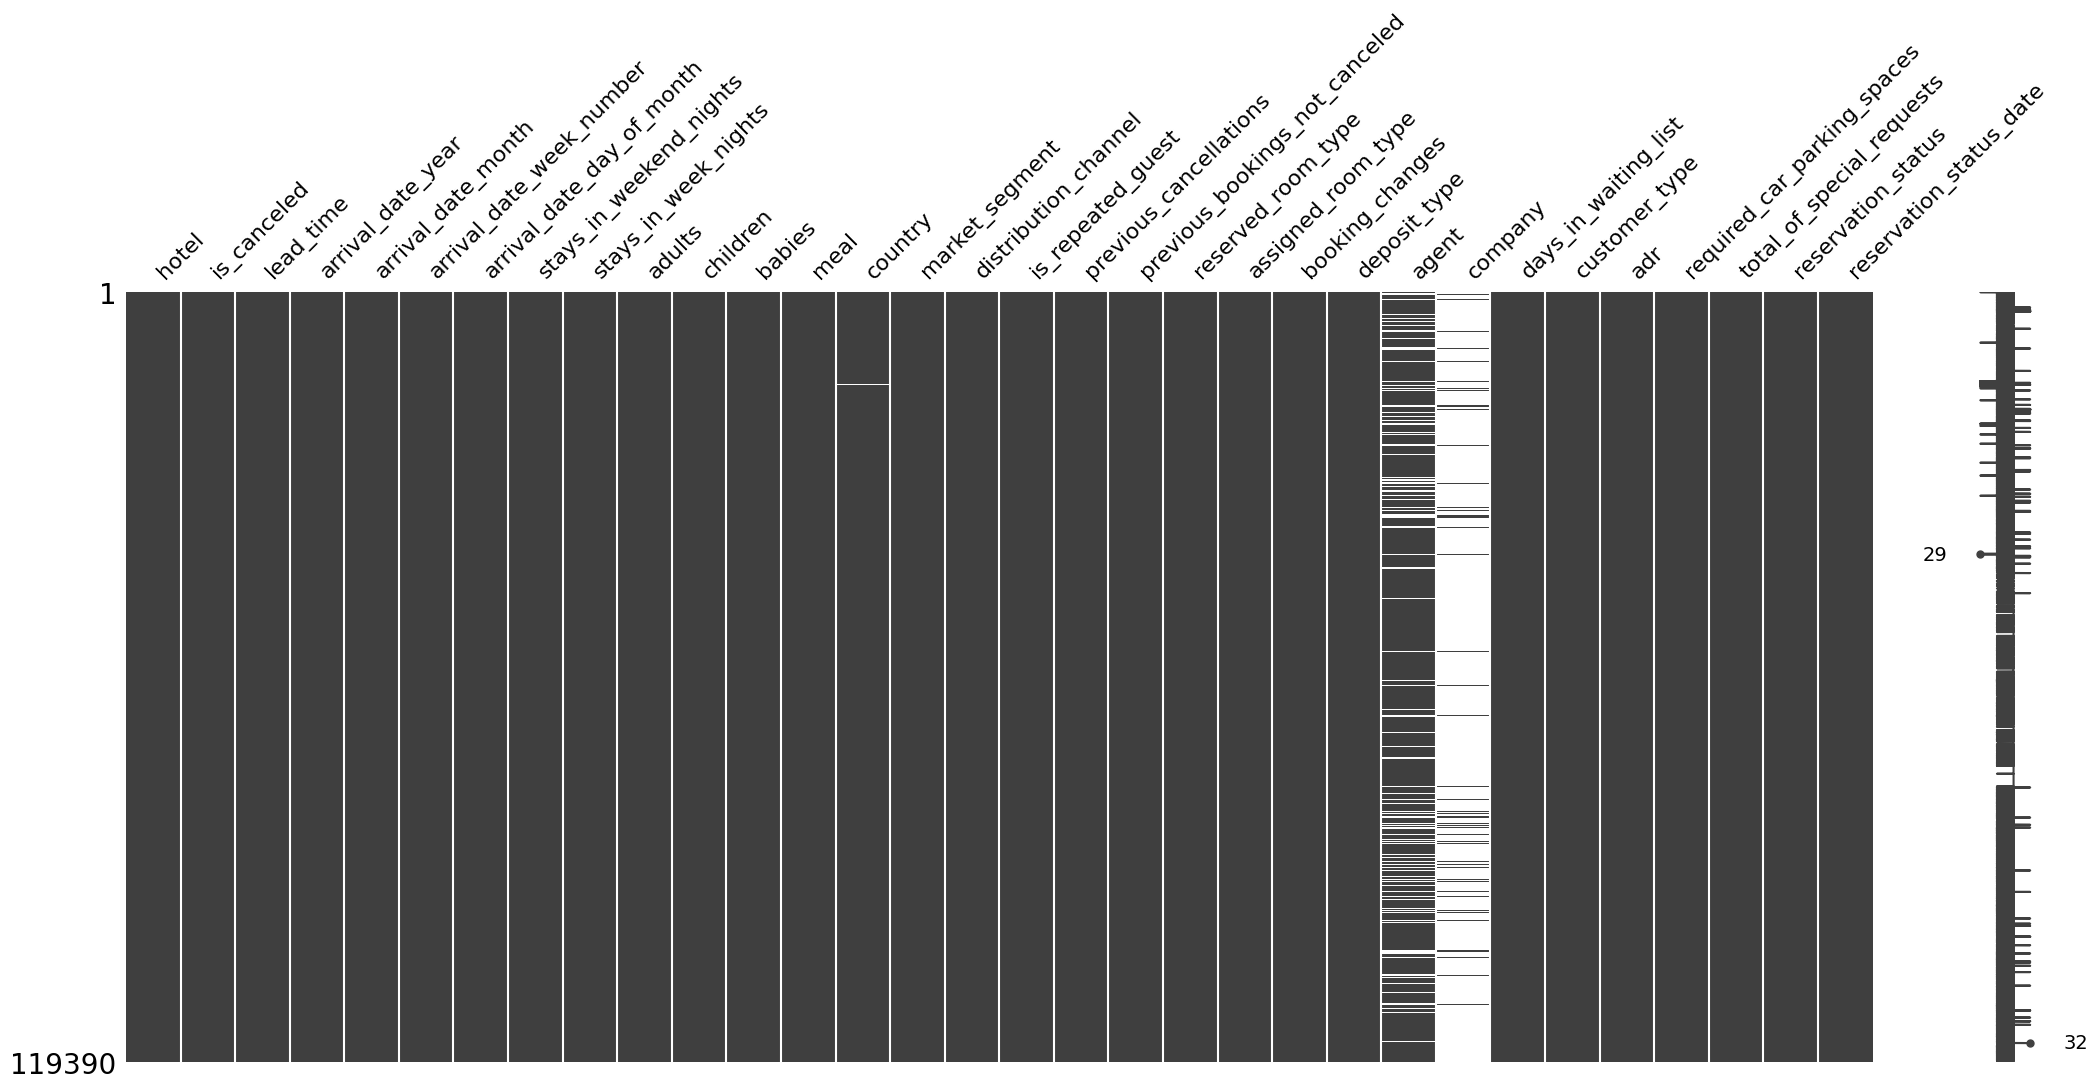

In [6]:
msno.matrix(df)

In [7]:
def missing_percentage(df): 
    # A function for returning missing ratios.
    
    total_nan = df.isnull().sum()
    total_nan_series = pd.Series(total_nan, index=df.columns)
    total = total_nan_series.sort_values(ascending=False)

    percent_nan = 100* df.isnull().sum() / len(df)
    percent_nan_series = pd.Series(percent_nan, index=df.columns)
    percent = percent_nan_series.sort_index(ascending=False)
    
    return pd.concat([total,percent],axis=1,keys=['Total','Percent'])

,company,agent,country,children,reserved_room_type,assigned_room_type,booking_changes,deposit_type,hotel,previous_cancellations,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,previous_bookings_not_canceled,is_repeated_guest,is_canceled,distribution_channel,market_segment,meal,babies,adults,stays_in_week_nights,stays_in_weekend_nights,arrival_date_day_of_month,arrival_date_week_number,arrival_date_month,arrival_date_year,lead_time,reservation_status_date
Total,112593.000000,16340.000000,488.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Percent,94.306893,13.686238,0.408744,0.003350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


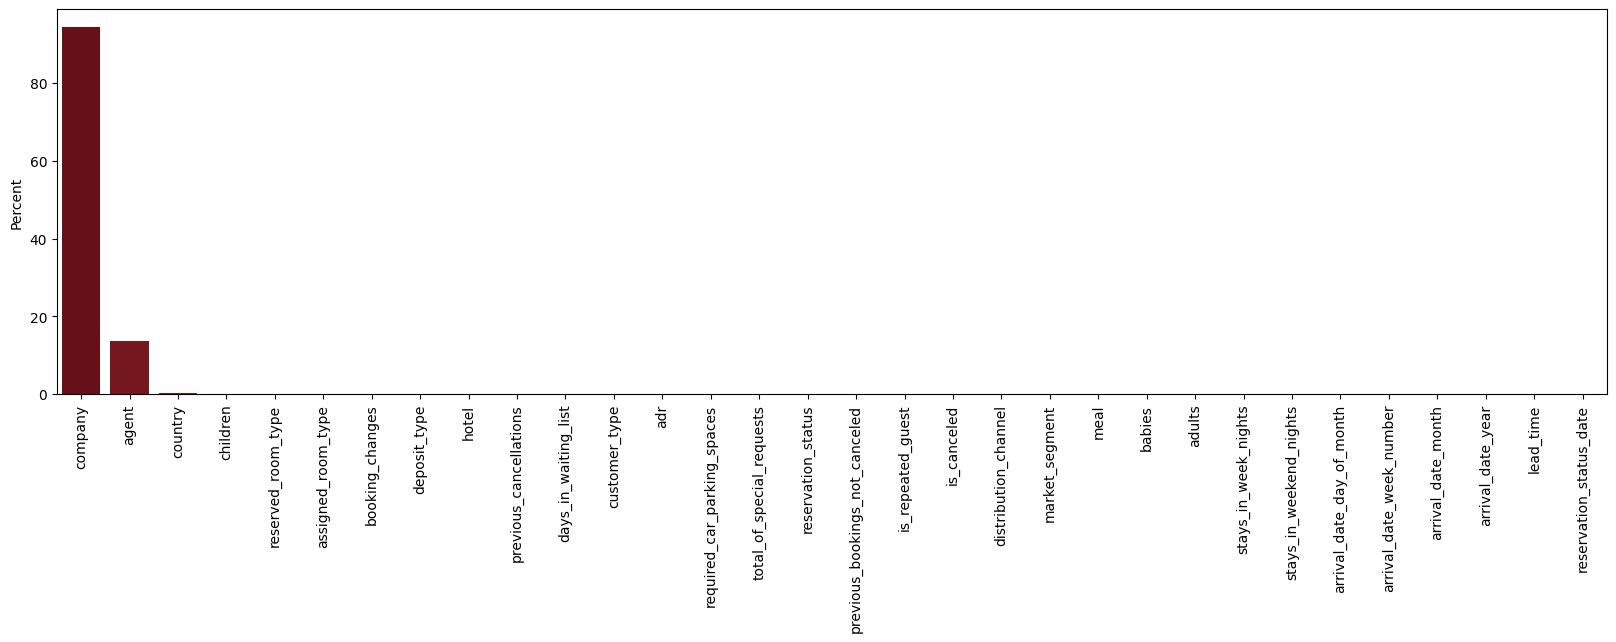

In [8]:
# checking 'NaN' values.

missing = missing_percentage(df)


fig,ax = plt.subplots(figsize=(20,5))
sns.barplot(x=missing.index,y='Percent',data=missing,palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds',axis=1))

In [9]:
# Since 94% of rows are missing for company column, therefore, we drop the company column
df = df.drop(['company'],axis=1)

# The agent column has 13% missing values, we can either keep it or delete it. 
# By checking the metadata, agent column is the ID of the travel agency that made the booking, which is not relevant. 
# Therefore, we delete the agent column as well.
df = df.drop(['agent'],axis=1)

# A few of these features appear that it is just one or two rows missing the data, 
# It makes more sense to drop a row, based on missing column features.
df.dropna(subset=["children","country"],inplace=True)

In [10]:
# Now, no more missing values in the dataset.
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

In [11]:
# Check duplicated data.
df.duplicated().sum()

31984

In [12]:
# Remove duplicated data.
df.drop_duplicates(inplace = True)

In [13]:
# Now, no more duplicated data, and our data cleaning process have been finished.
df.duplicated().sum()

0

# 2. Exploratory data analysis (EDA)

In [14]:
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
df_booked = df.loc[df["is_canceled"] == 0]

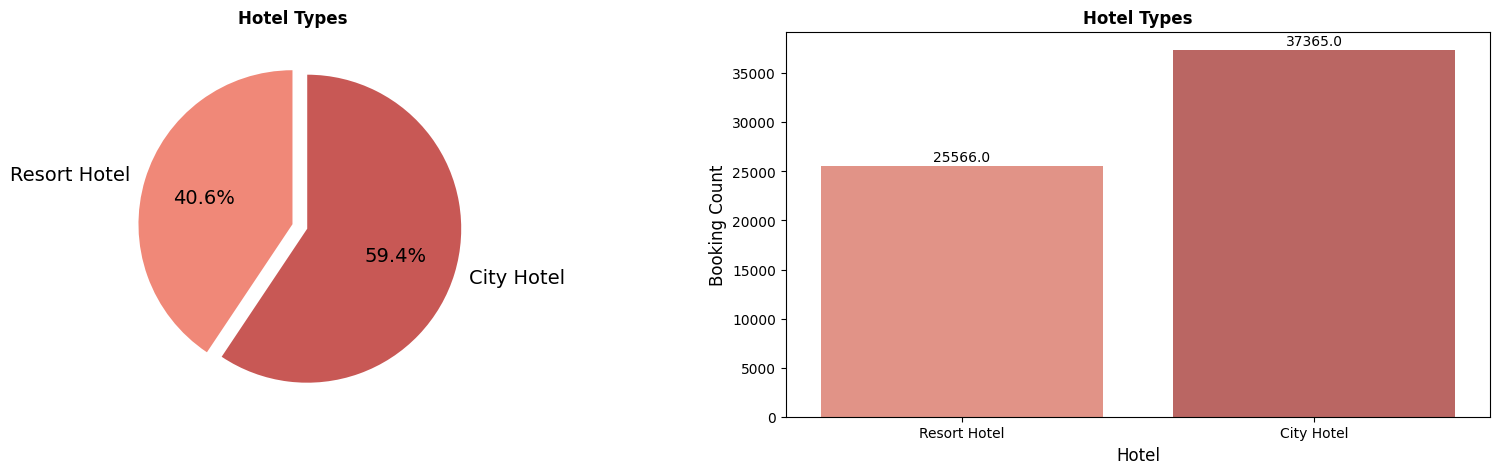

In [15]:
# Hotel type booking distribution

# Indexing labels. (By checking the metadata)
labels = ['Resort Hotel','City Hotel']

# Convert value counts to list
resort_hotel_sizes = df_booked['hotel'].value_counts()['Resort Hotel']
city_hotel_sizes = df_booked['hotel'].value_counts()['City Hotel']
sizes = [resort_hotel_sizes,city_hotel_sizes]

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
# As the name suggest, explode will determine how much each section is separated from each other 
explode = (0, 0.1)
plt.title('Hotel Types', weight='bold')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 14},colors={'#C85855', '#F08878'})

plt.subplot(1, 2, 2)
plt.title('Hotel Types', weight='bold')
ax = sns.countplot(x='hotel', data=df_booked, palette=sns.color_palette(['#F08878','#C85855']))
plt.xlabel('Hotel', fontsize=12)
plt.ylabel('Booking Count', fontsize=12)

# 在每个柱子上添加标签
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()-550), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.savefig("hotel type.png", dpi=300)

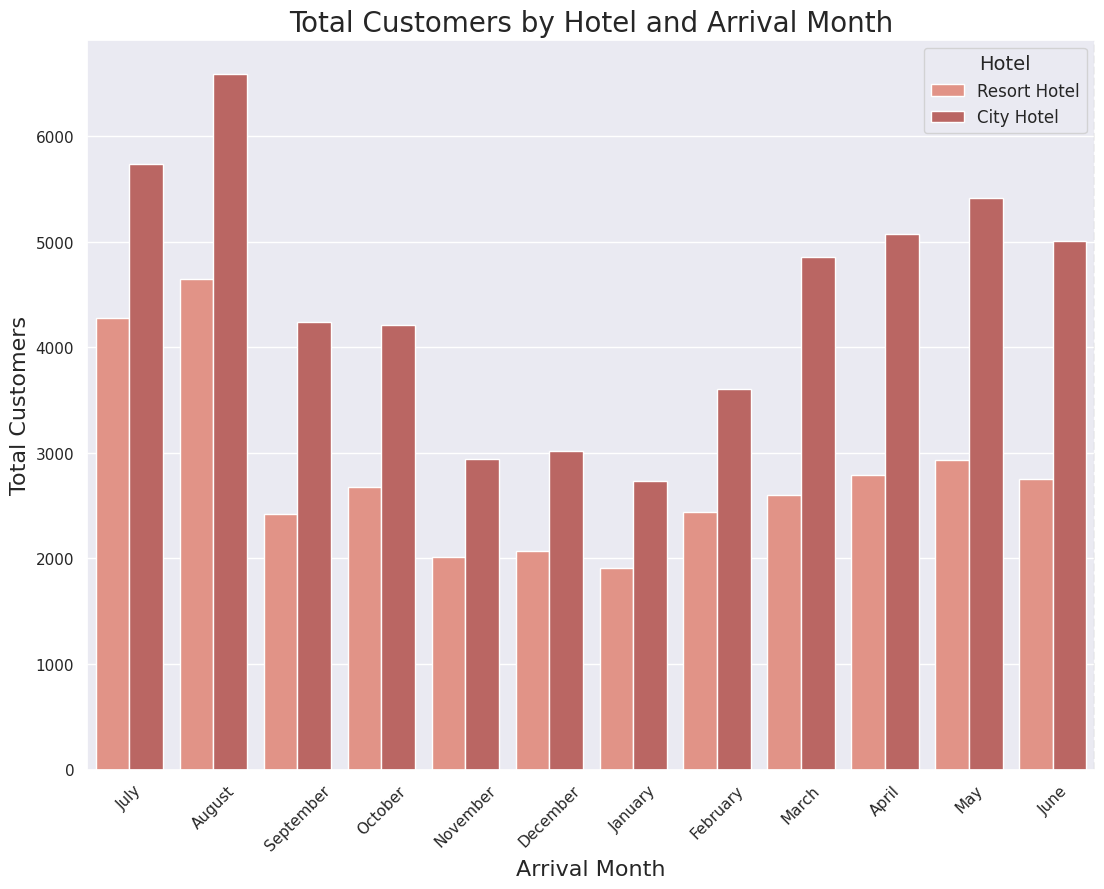

In [16]:
plt.figure(figsize=(13, 10))
sns.set(style="darkgrid")

plt.title("Total Customers by Hotel and Arrival Month", fontdict={'fontsize': 20})

ax = sns.countplot(x="arrival_date_month", hue='hotel', data=df, palette=sns.color_palette(['#F08878', '#C85855']))

plt.xlabel("Arrival Month", fontsize=16)
plt.ylabel("Total Customers", fontsize=16)

plt.rcParams.update({'font.size': 14})

plt.legend(title='Hotel', fontsize=12, title_fontsize=14)

ax.yaxis.grid(True)
ax.axvline(x=11.5, linestyle='--', color='gray')

plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)

plt.savefig("Total Customers by Hotel and Arrival Month.png", dpi=300)


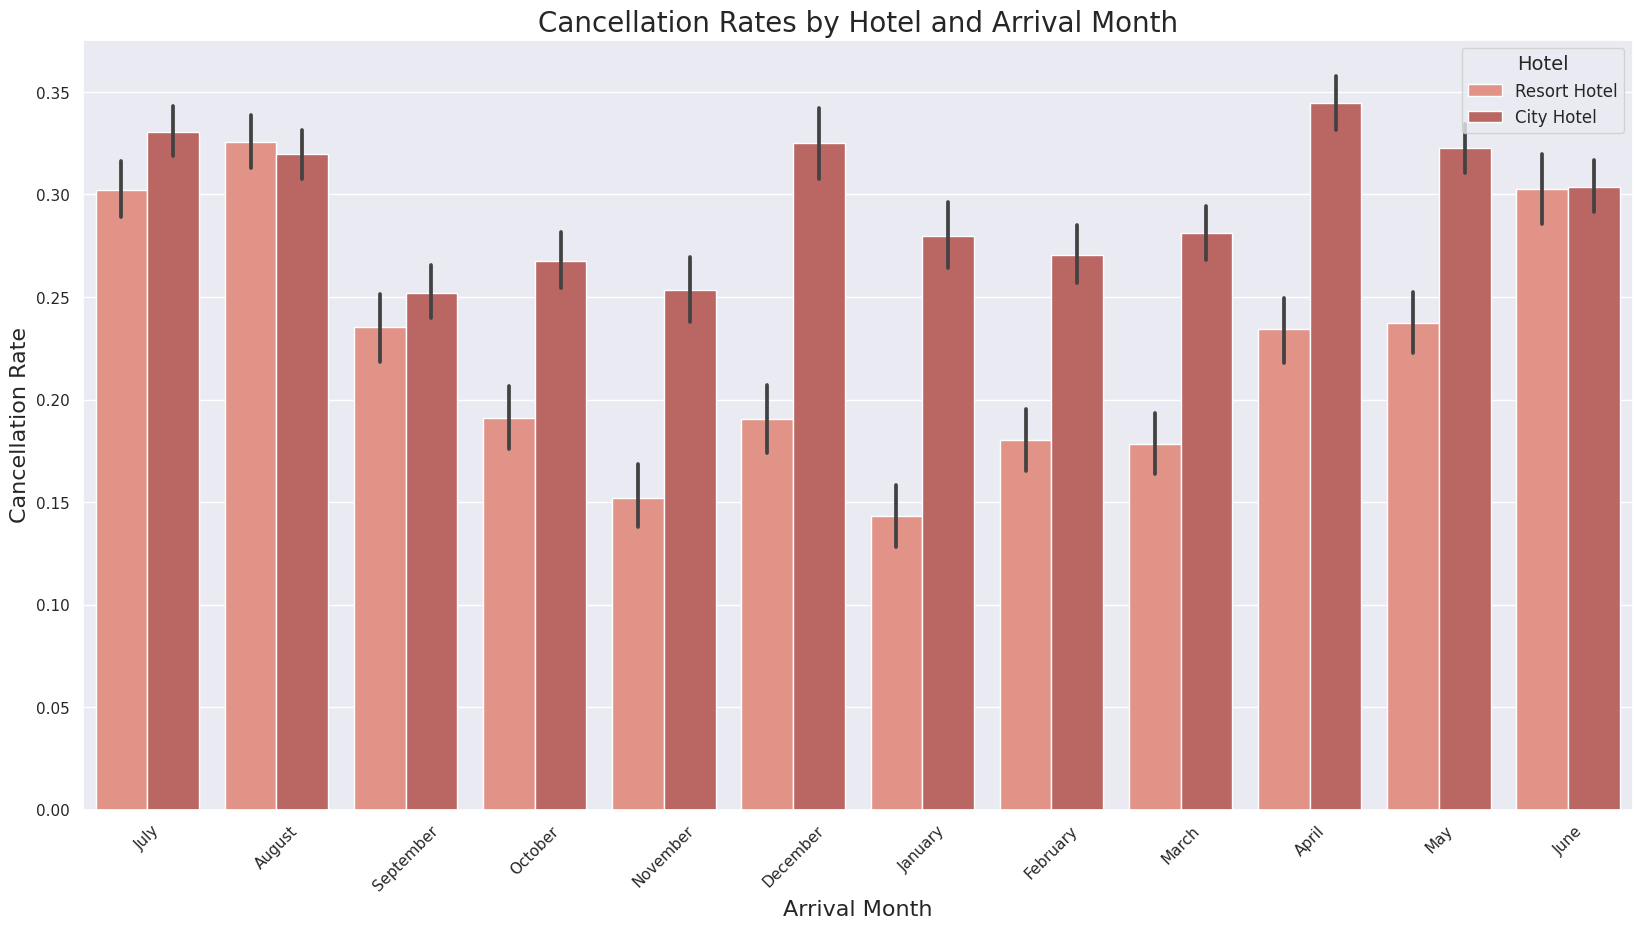

In [17]:

plt.figure(figsize=(20, 10))

sns.barplot(x='arrival_date_month', y='is_canceled', hue='hotel', data=df, palette=sns.color_palette(['#F08878', '#C85855']))

plt.title('Cancellation Rates by Hotel and Arrival Month', fontsize=20)
plt.xlabel('Arrival Month', fontsize=16)
plt.ylabel('Cancellation Rate', fontsize=16)

plt.rcParams.update({'font.size': 14})

plt.xticks(rotation=45)

plt.legend(title='Hotel', fontsize=12, title_fontsize=14)

plt.savefig("Cancellation Rates by Hotel and Arrival Month.png", dpi=300)


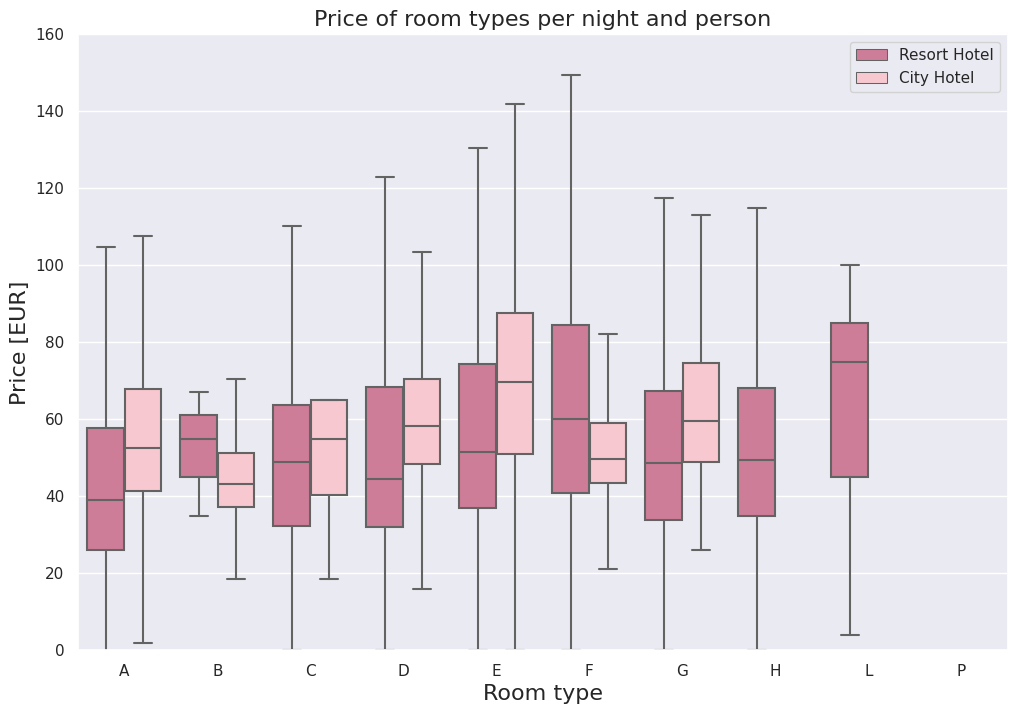

In [18]:
# Price of room types per night and person
df_new = df.copy()
df_new["totalpeople"] = df_new["adults"]+ df_new["children"] + df_new["babies"]
df_new["adr_pp"] = df_new["adr"] / df_new["totalpeople"]
room_prices = df_new[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
#mycolor = {'#526A43','#B2C7A2'}
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["Resort Hotel","City Hotel"],
            fliersize=0,palette=['palevioletred','pink'])
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.savefig("Price_of_room_types_per_night_and_person.png", dpi=300)


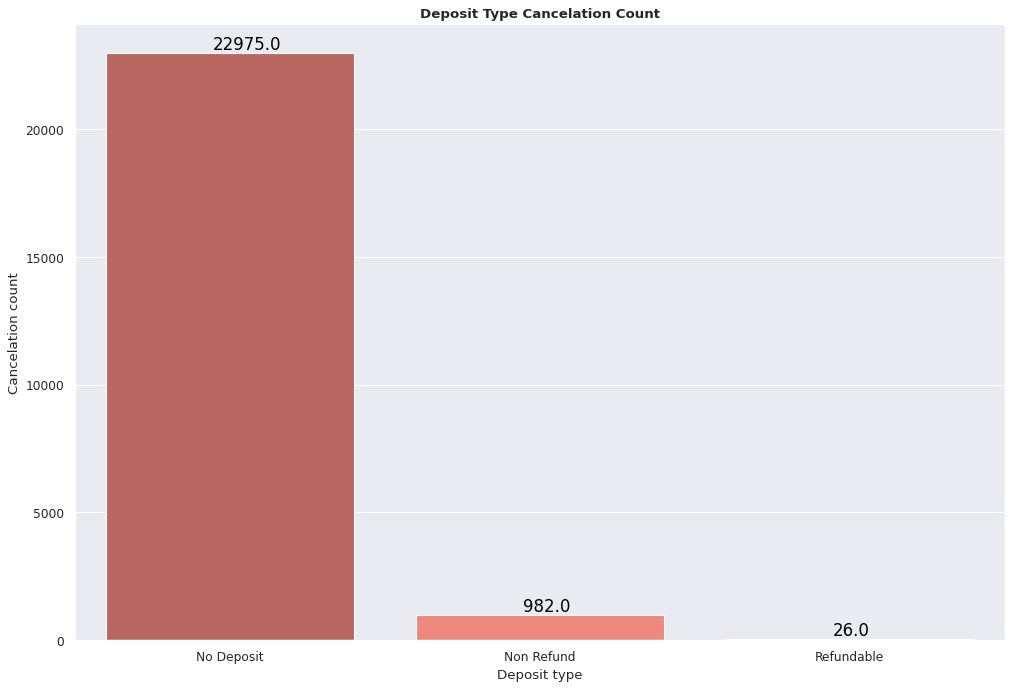

In [19]:
# Deposit type vs cancelation
df_canceled = df.loc[df["is_canceled"] == 1]
fig,ax = plt.subplots(figsize=(15,10), dpi=80)
plt.title('Deposit Type Cancelation Count', weight='bold')
sns.countplot(x='deposit_type', data = df_canceled, palette = sns.color_palette(['#C85855','#FF796B','#FFD3D2']))
plt.xlabel('Deposit type', fontsize=12)
plt.ylabel('Cancelation count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.345, p.get_height()+150), color='black', size=15)
plt.savefig("Deposit_Type_Cancelation_Count.png", dpi=300)

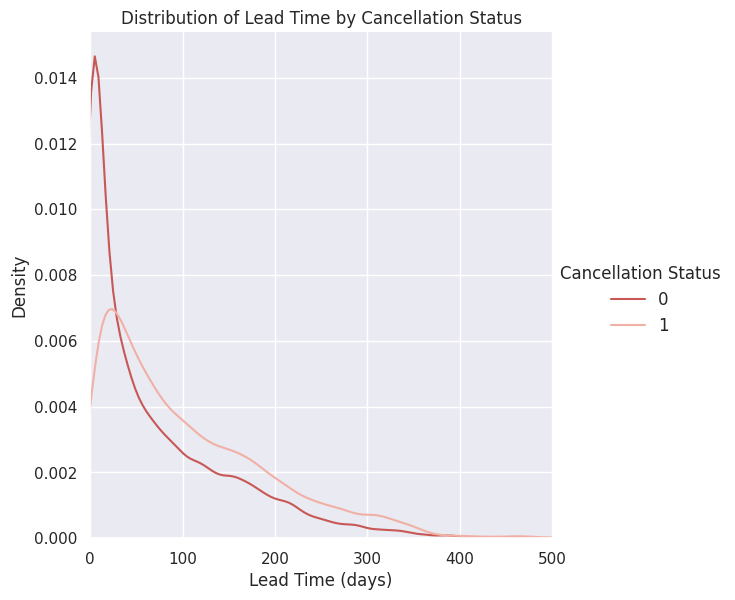

In [20]:
# create FacetGrid plot:
g = sns.FacetGrid(df, palette=sns.color_palette(['#C85855', '#F1B0A5']), 
                  hue='is_canceled', height=6, xlim=(0, 500))
g.map(sns.kdeplot, 'lead_time')

# set title and axis labels:
g.set(title='Distribution of Lead Time by Cancellation Status', 
      xlabel='Lead Time (days)', 
      ylabel='Density')

# set legend title and font size:
g.add_legend(title='Cancellation Status', fontsize=12, title_fontsize=14)

# save plot:
plt.savefig("Lead_Time_Distribution.png", dpi=300)


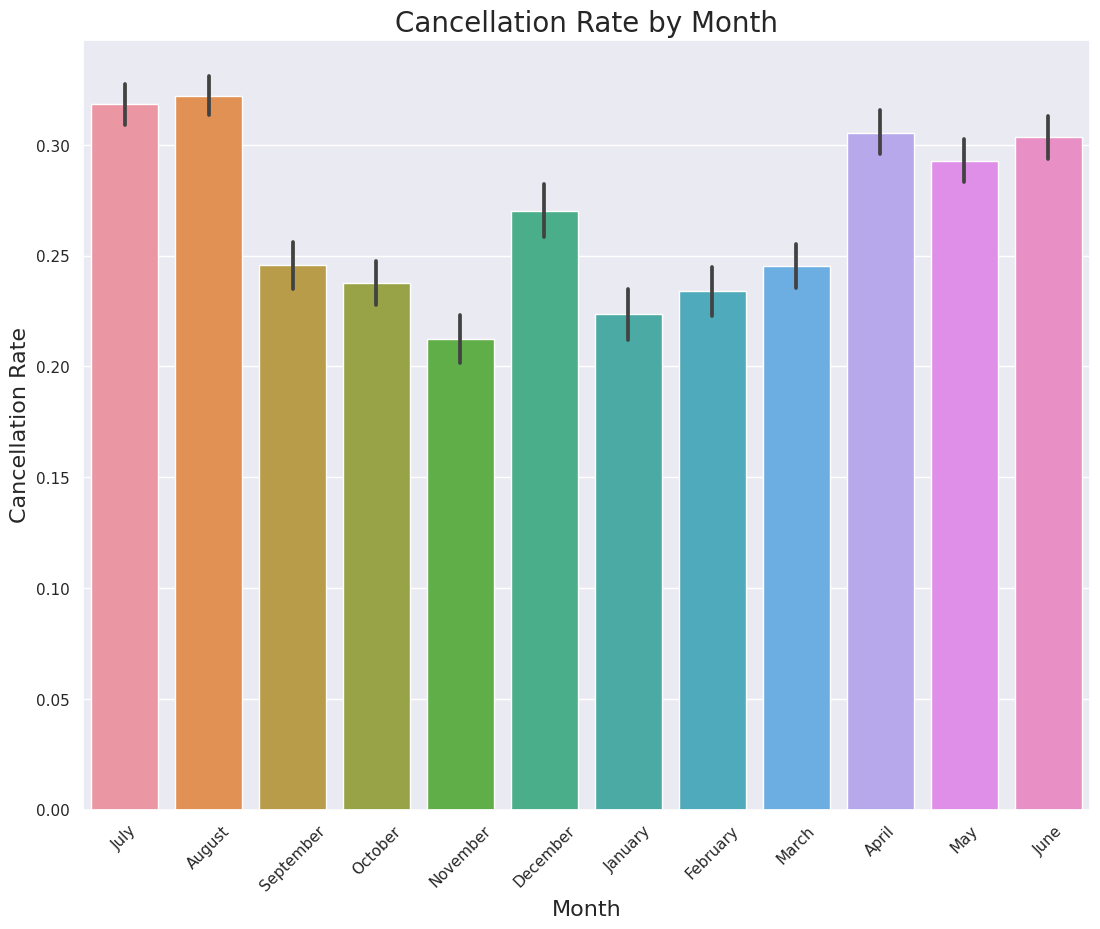

In [21]:
# create bar plot:
plt.figure(figsize=(13, 10))
sns.barplot(x='arrival_date_month', y='is_canceled', data=df)

# set title and axis labels:
plt.title('Cancellation Rate by Month', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Cancellation Rate', fontsize=16)

# set x-tick label rotation:
plt.xticks(rotation=45)

# save plot:
plt.savefig("Cancellation_Rate_by_Month.png", dpi=300)


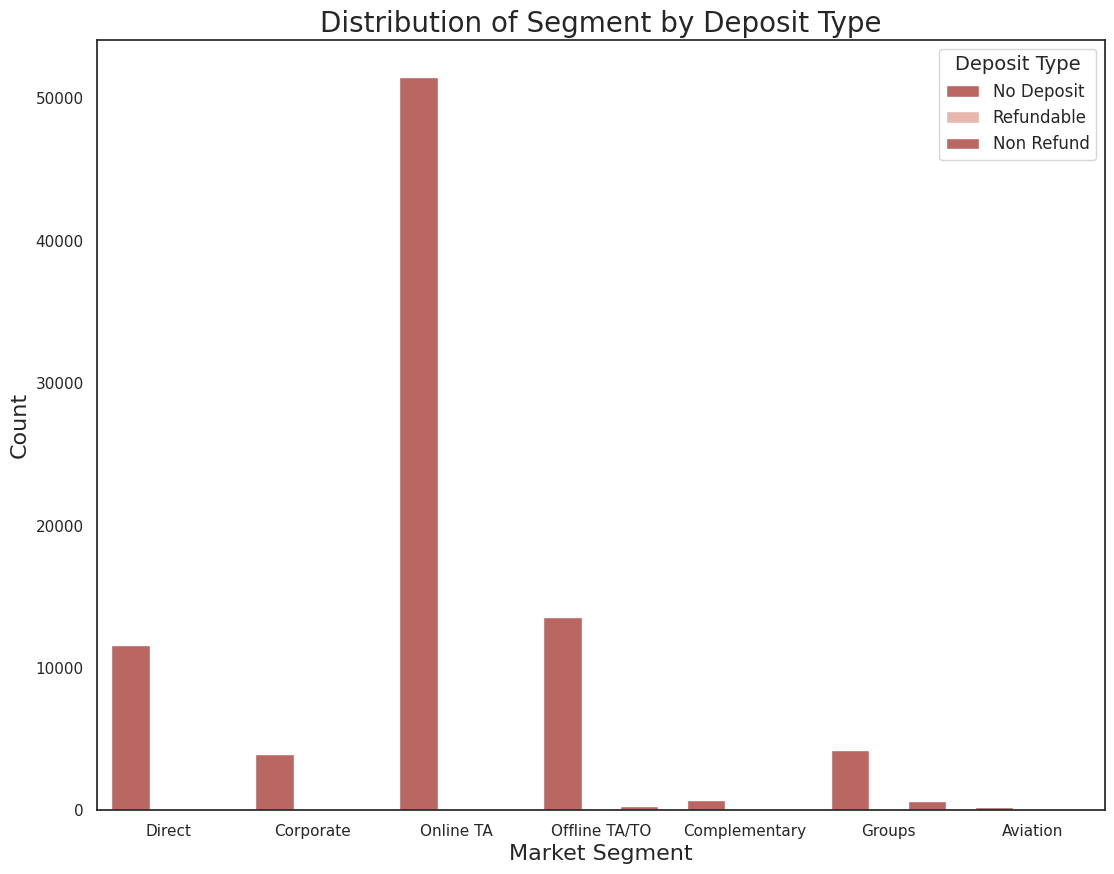

In [22]:
# create count plot:
plt.figure(figsize=(13, 10))
sns.set_style("white")
sns.countplot(x="market_segment", hue="deposit_type", data=df, 
              palette=sns.color_palette(['#C85855', '#F1B0A5']))

# set title and axis labels:
plt.title("Distribution of Segment by Deposit Type", fontsize=20)
plt.xlabel("Market Segment", fontsize=16)
plt.ylabel("Count", fontsize=16)

# set legend properties:
plt.legend(title='Deposit Type', fontsize=12, title_fontsize=14)

# save plot:
plt.savefig("Segment_by_Deposit_Type.png", dpi=300)


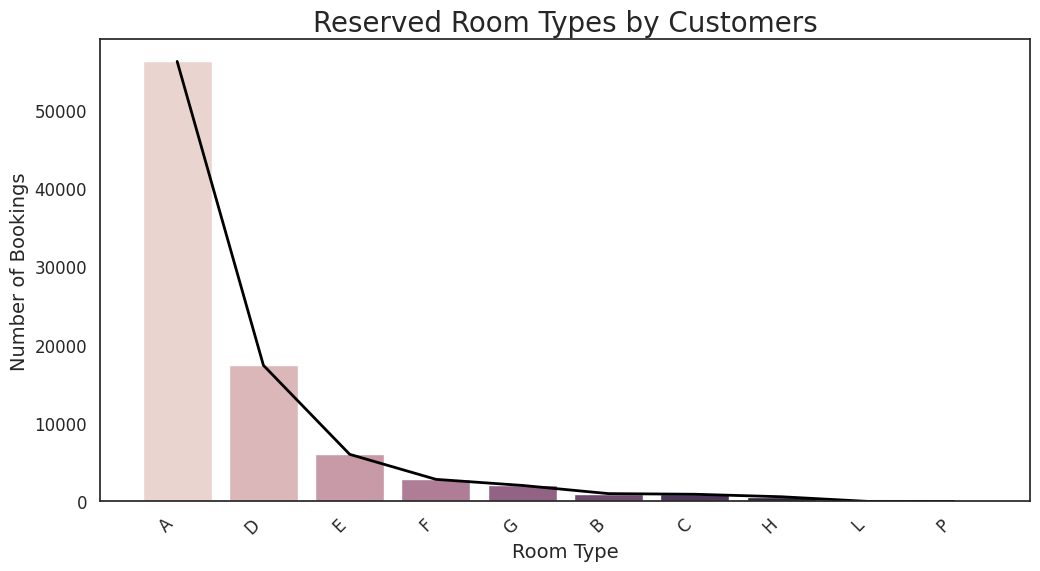

In [23]:
rsv_room = df['reserved_room_type'].value_counts().reset_index().rename(columns={'index':'reserved_room_type','reserved_room_type':'Count'})
plt.figure(figsize=(12,6))
sns.set_style("white")
sns.barplot(x=rsv_room['reserved_room_type'],y=rsv_room['Count'],palette = sns.cubehelix_palette(8))
sns.lineplot(x=rsv_room['reserved_room_type'],y=rsv_room['Count'],color='black',lw=2)
plt.title("Reserved Room Types by Customers",fontsize=20)
plt.xlabel("Room Type",fontsize=14)
plt.ylabel("Number of Bookings",fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Reserved_Room_Types_by_Customers.png", dpi=300)

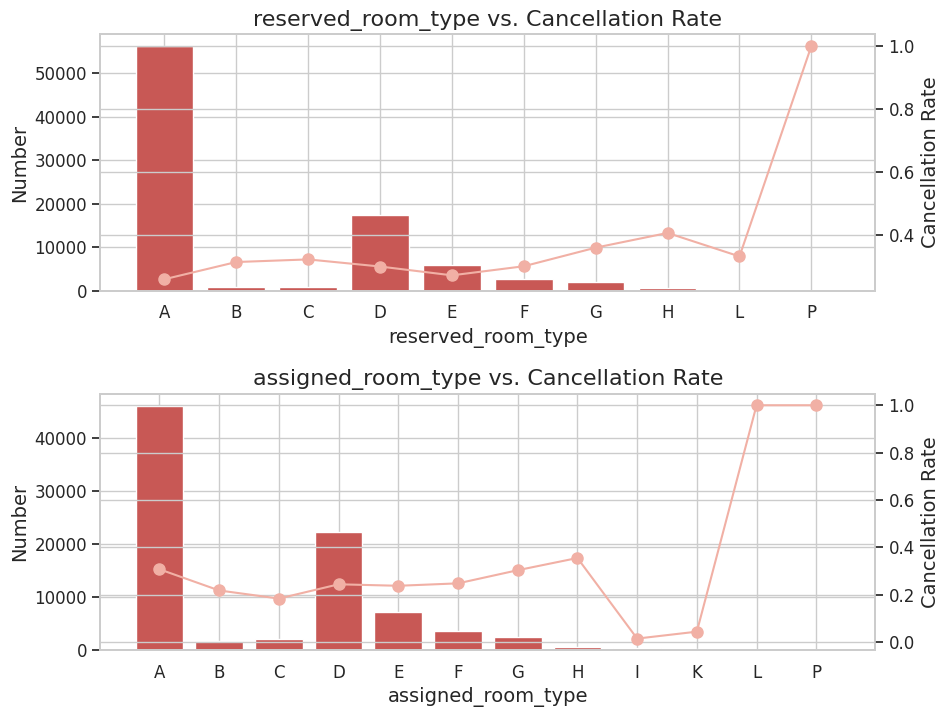

In [24]:
# 设置整体样式
sns.set_style("whitegrid")

# 设置图形大小
fig = plt.figure(figsize=(10, 8))

# 循环遍历两种房间类型
index = 1
for room_type in ['reserved_room_type', 'assigned_room_type']:
    # 创建子图
    ax1 = fig.add_subplot(2, 1, index)
    index += 1
    ax2 = ax1.twinx()
    
    # 绘制柱状图
    ax1.bar(
        df.groupby(room_type).size().index,
        df.groupby(room_type).size(), color='#C85855')
    
    # 设置柱状图的标签和标题
    ax1.set_xlabel(room_type, fontsize=14)
    ax1.set_ylabel('Number', fontsize=14)
    ax1.set_title(f'{room_type} vs. Cancellation Rate', fontsize=16)
    
    # 绘制折线图
    ax2.plot(
        df.groupby(room_type)['is_canceled'].mean(), 'o-', color='#F1B0A5', markersize=8)
    
    # 设置折线图的标签
    ax2.set_ylabel('Cancellation Rate', fontsize=14)
    
    # 设置柱状图和折线图的轴标签字体大小
    ax1.tick_params(labelsize=12)
    ax2.tick_params(labelsize=12)
    
    # 调整布局
    plt.subplots_adjust(hspace=0.4)
    
plt.savefig("reserved_room_type.vs.cancellation_rate.png",dpi=300)


In [25]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = df.loc[(df["hotel"] == "Resort Hotel") & (df["is_canceled"] == 0)]
ch = df.loc[(df["hotel"] == "City Hotel") & (df["is_canceled"] == 0)]

In [26]:
# get number of acutal guests by country
country_data = pd.DataFrame(df.loc[df["is_canceled"] == 0]["country"].value_counts())
#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn",color_discrete_sequence=px.colors.sequential.matter)
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()
fig.write_html('Home_country_of_guests.html')

In [27]:
# show on map
guest_map = px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guests in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Burg,
                    title="Home country of guests")
guest_map.show()
guest_map.write_html('Home_country_of_guests_map.html')

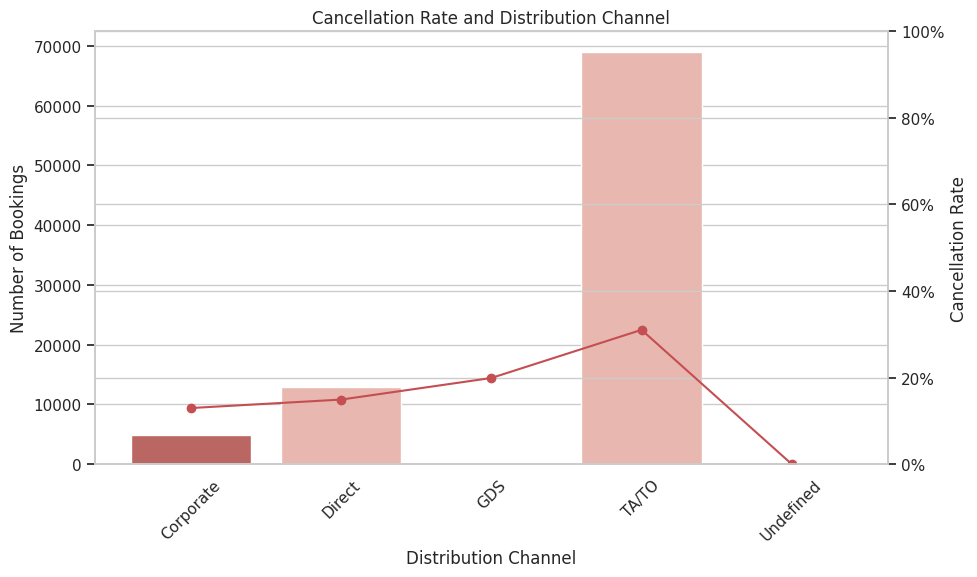

In [28]:
import matplotlib.ticker as mtick
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.countplot(
    x=df['distribution_channel'],
    order=df.groupby('distribution_channel')['is_canceled'].mean().index,
    ax=ax1,
    palette=sns.color_palette(['#C85855','#F1B0A5']))
ax1.set_xlabel('Distribution Channel')
ax2.plot(df.groupby('distribution_channel')['is_canceled'].mean(), 'ro-')
ax1.set_ylabel('Number of Bookings')
ax2.set_ylabel('Cancellation Rate')
plt.gcf().set_size_inches(10, 6)
ax1.tick_params(axis='x', labelrotation=45)
ax2.set_ylim([0, 1])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title('Cancellation Rate and Distribution Channel')
plt.tight_layout()
plt.savefig("Cancellation Rate and Distribution Channel.png", dpi=300)

<ipython-input-29-4de4eb45b597>:11: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




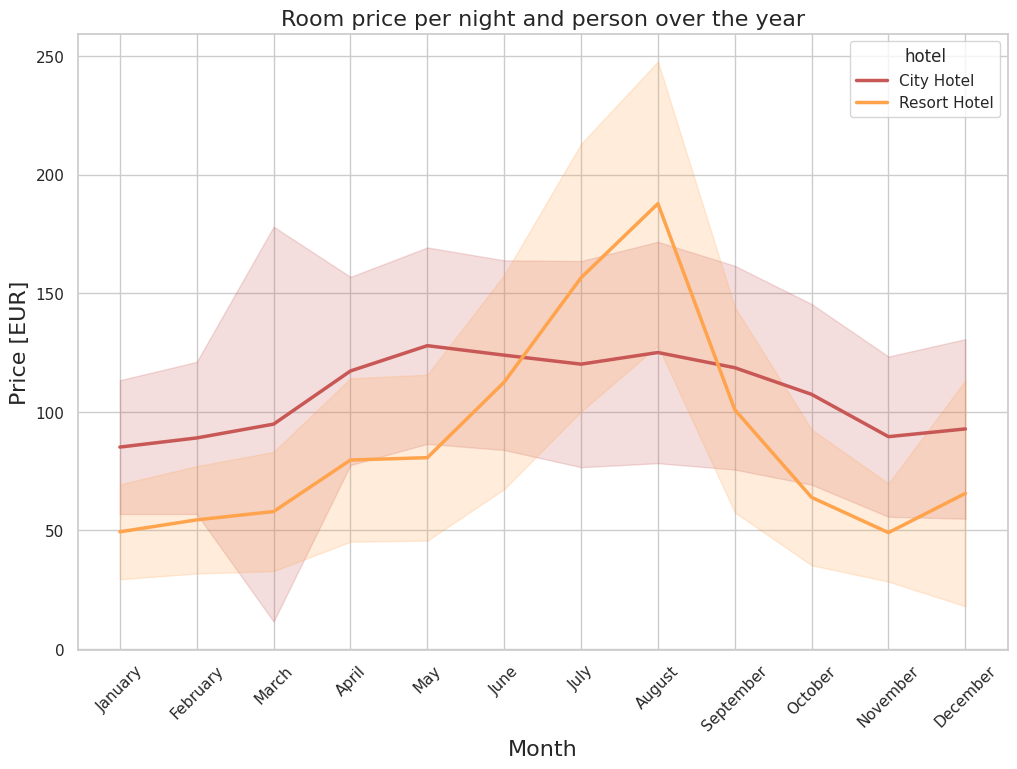

In [29]:
# grab data:
room_prices_mothly = df[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5), palette=sns.color_palette(['#C85855','#FFA44D']))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.savefig("Room price per night and person over the year.png",dpi=300)

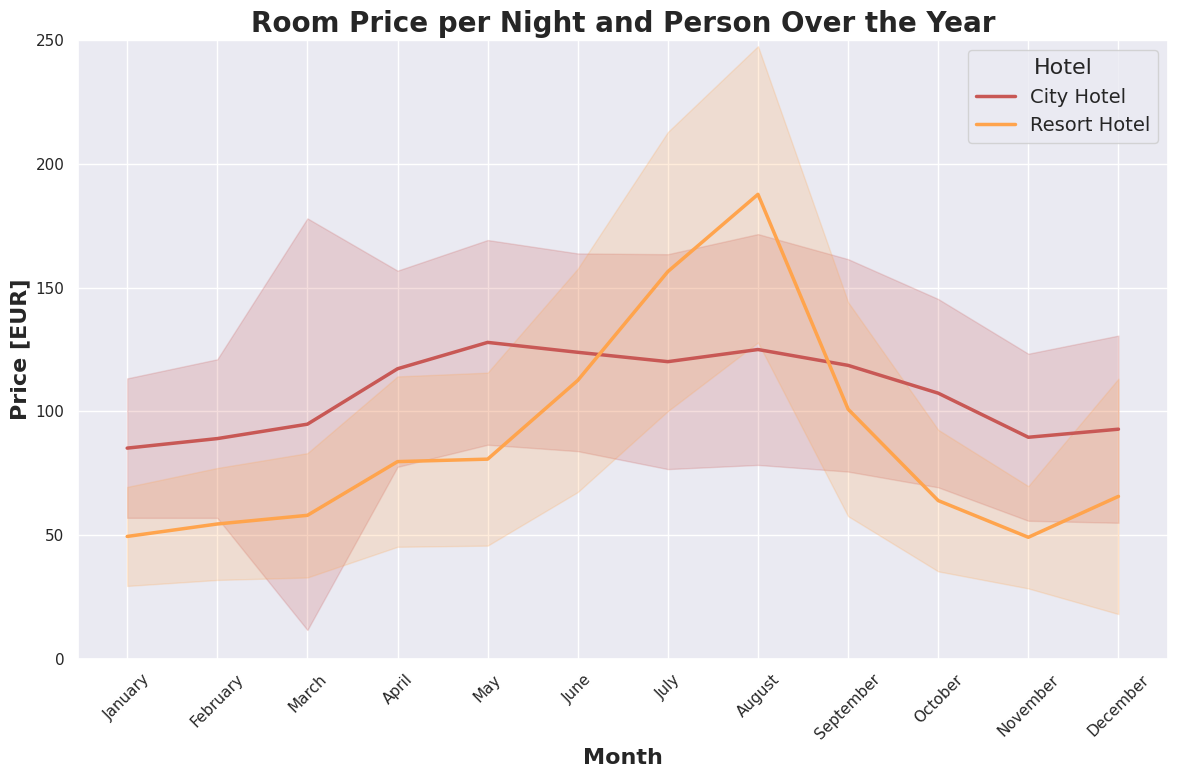

In [30]:
# grab data:
room_prices_mothly = df[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"], categories=ordered_months, ordered=True)

# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.set_style("darkgrid")
sns.lineplot(x="arrival_date_month", y="adr", hue="hotel", data=room_prices_mothly, 
             hue_order=["City Hotel", "Resort Hotel"], errorbar="sd", size="hotel", sizes=(2.5, 2.5), 
             palette=sns.color_palette(['#C85855', '#FFA44D']))
plt.title("Room Price per Night and Person Over the Year", fontsize=20, fontweight="bold")
plt.xlabel("Month", fontsize=16, fontweight="bold")
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16, fontweight="bold")
plt.ylim(0, 250)
plt.legend(title="Hotel", fontsize=14, title_fontsize=16)
plt.tight_layout()

plt.savefig("Room_price_per_night_and_person_over_the_year.png",dpi=300)

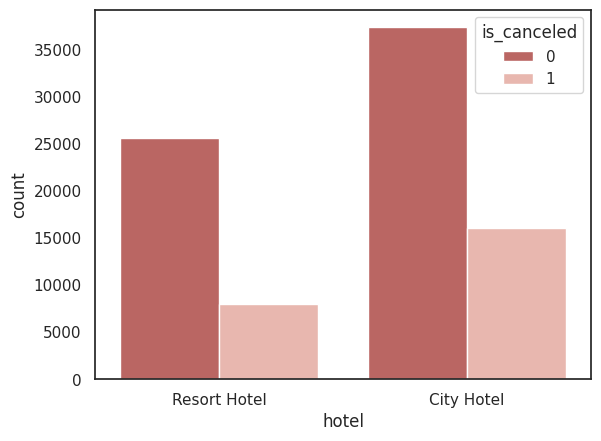

In [31]:
sns.set_style("white")
sns.countplot(x='hotel', hue='is_canceled', data=df,palette=sns.color_palette(['#C85855','#F1B0A5']))
plt.savefig("Room_price_per_night_and_person_over_the_year.png",dpi=300)

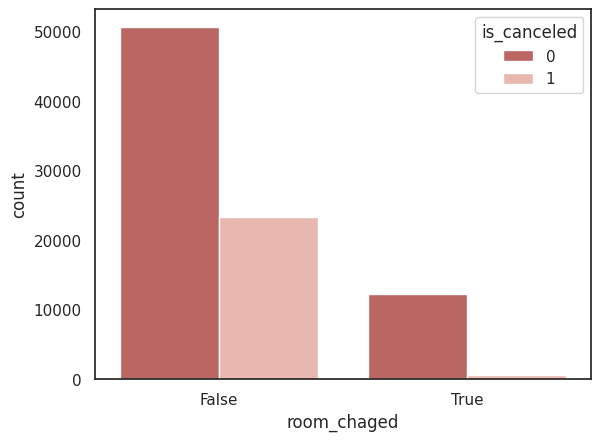

In [32]:
# 房间类型变更对取消预定的影响
df['room_chaged']=df['reserved_room_type']!=df['assigned_room_type']
sns.set_style("white")
sns.countplot(x='room_chaged',hue='is_canceled',data=df,palette=sns.color_palette(['#C85855','#F1B0A5']))
plt.savefig("Room_price_per_night_and_person_over_the_year.png",dpi=300)

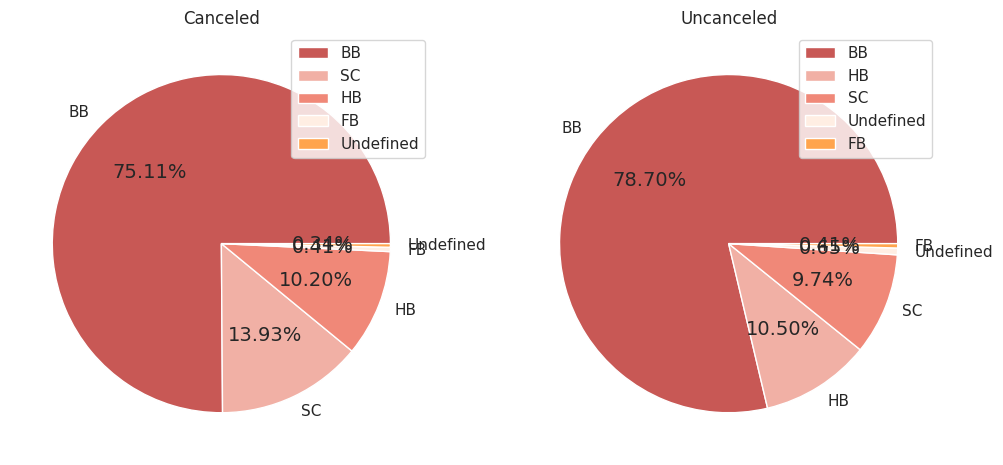

In [33]:
# 查看餐食类型与取消预订的关系
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.pie(df[df['is_canceled'] == 1].meal.value_counts(),
        labels=df[df['is_canceled'] == 1].meal.value_counts().index,
        autopct="%.2f%%",colors=["#C85855","#F1B0A5","#F08878","#FFEEE3","#FFA44D"])
plt.legend(loc=1)
plt.title('Canceled')
plt.subplot(122)
plt.pie(df[df['is_canceled'] == 0].meal.value_counts(),
        labels=df[df['is_canceled'] == 0].meal.value_counts().index,
        autopct="%.2f%%",colors=["#C85855","#F1B0A5","#F08878","#FFEEE3","#FFA44D"])
plt.legend(loc=1)
plt.title('Uncanceled')
plt.savefig("cancel_vs_uncancle.png",dpi=300)

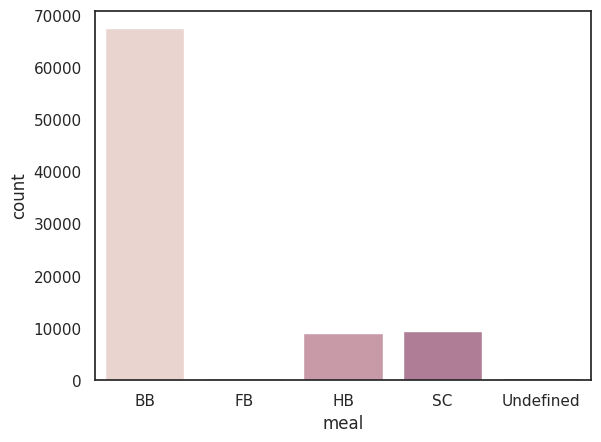

In [34]:
sns.set_style("white")
sns.countplot(x='meal',data=df,palette=sns.cubehelix_palette(8))
plt.savefig("meal_count.png",dpi=300)

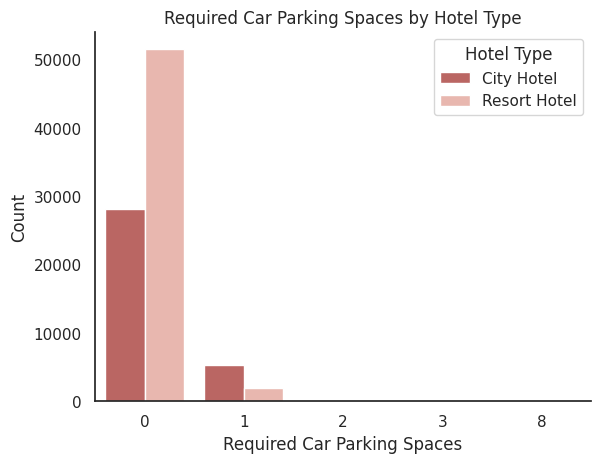

In [35]:
sns.set_style("white")
ax = sns.countplot(x='required_car_parking_spaces',hue='hotel',data=df,palette=sns.color_palette(['#C85855','#F1B0A5']))

# Add labels to each bar in the plot
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + 0.15, p.get_height() + 10))

# Set the title and axes labels
plt.title('Required Car Parking Spaces by Hotel Type')
plt.xlabel('Required Car Parking Spaces')
plt.ylabel('Count')

# Remove the top and right spines
sns.despine(top=True, right=True)

# Modify the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['City Hotel', 'Resort Hotel'], title='Hotel Type')

plt.savefig("required_car_count.png",dpi=300)



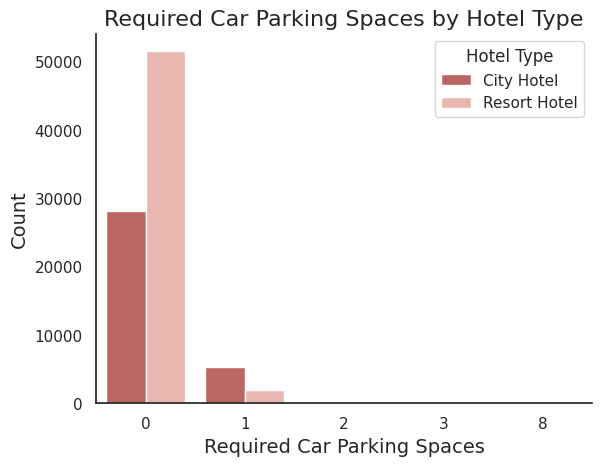

In [36]:
# Set plot style
sns.set_style("white")

# Create countplot
ax = sns.countplot(x='required_car_parking_spaces', hue='hotel', data=df, palette=sns.color_palette(['#C85855','#F1B0A5']))

# Set title and axes labels
plt.title('Required Car Parking Spaces by Hotel Type', fontsize=16)
plt.xlabel('Required Car Parking Spaces', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Remove top and right spines
sns.despine(top=True, right=True)

# Modify the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['City Hotel', 'Resort Hotel'], title='Hotel Type')

# Save the figure
plt.savefig("required_car_count.png", dpi=300)


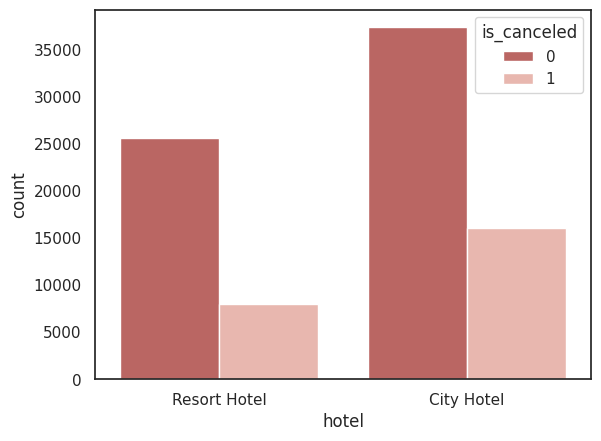

In [37]:
sns.set_style("white")
sns.countplot(x='hotel',hue='is_canceled',data=df,palette=sns.color_palette(['#C85855','#F1B0A5']))
plt.savefig("hotel_count.png",dpi=300)

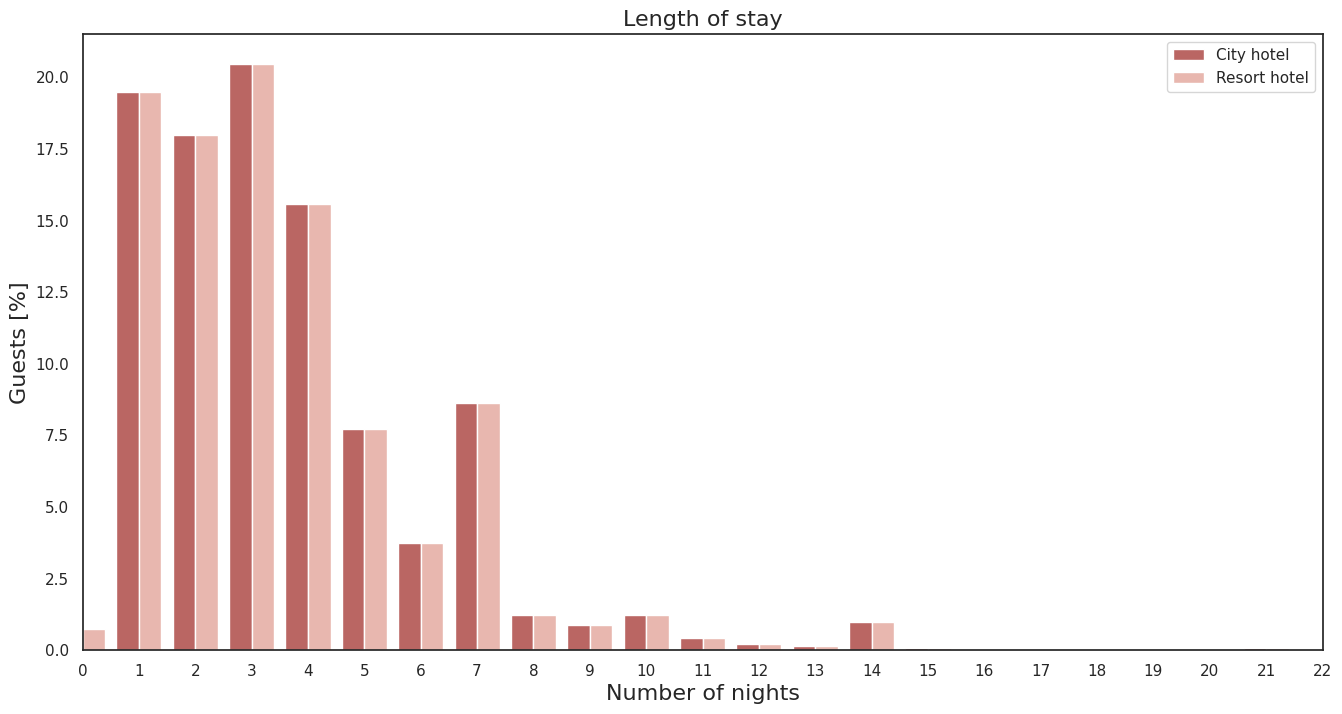

In [38]:
# 构造数据
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

num_nights_res =   list(df["total_nights"].value_counts().index)
num_bookings_res = list(df["total_nights"].value_counts())
rel_bookings_res =      df["total_nights"].value_counts() / sum(num_bookings_res) * 100


num_nights_cty =   list(df["total_nights"].value_counts().index)
num_bookings_cty = list(df["total_nights"].value_counts())
rel_bookings_cty =      df["total_nights"].value_counts() / sum(num_bookings_cty) * 100 


res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)
#add labels
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.02))

#show figure:
plt.figure(figsize=(16, 8))
sns.set_style("white")
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"],palette=sns.color_palette(['#C85855','#F1B0A5']))
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)

#add labels
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.02))

plt.savefig("length_of_stay.png",dpi=300)

# 2. Data Integration

In [39]:
# Data Integrate (Feature Integration)
# Convert data in columns 'hotel' and 'arrival_date_month'into numerical labels by our own definitions.
# It will be easier to fit in machine learning models later.
df['hotel'] = df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

df['arrival_date_month'] = df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 
                                                         'May':5, 'June':6, 'July':7,'August':8,
                                                         'September':9, 'October':10, 'November':11, 'December':12})

# df['deposit_type'] = df['deposit_type'].map({'No Deposit':0, 'Non Refund':1, 'Refundable':2})

In [40]:
# Integrate columns 'adults', 'children', and 'babies' into one categorical column.
# 1 for family, 0 for non-family.
def family(df):
    if ((df['adults'] > 0) & (df['children'] > 0)):
        val = 1
    elif ((df['adults'] > 0) & (df['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

In [41]:
def feature(df):
    df['is_family'] = df.apply(family, axis = 1)
    df['total_customer'] = df['adults'] + df['children'] + df['babies']
    df['total_nights_stayed'] = df['stays_in_weekend_nights']+ df['stays_in_week_nights']
    return df

df = feature(df)

# 'adults', 'babies', and 'children' columns was integrated into new features 'is_family' and 'total_customer'.
# 'reservation_status_date' column only recorded the date at which the last status was set.
#  Those columns are not that useful to us anymore, so we choose to drop them.
df = df.drop(columns = ['adults', 'babies', 'children', 'reservation_status_date'])

In [42]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,room_chaged,total_nights,is_family,total_customer,total_nights_stayed
0,0,0,342,2015,7,27,1,0,0,BB,...,Transient,0.00,0,0,Check-Out,False,0,0,2.0,0
1,0,0,737,2015,7,27,1,0,0,BB,...,Transient,0.00,0,0,Check-Out,False,0,0,2.0,0
2,0,0,7,2015,7,27,1,0,1,BB,...,Transient,75.00,0,0,Check-Out,True,1,0,1.0,1
3,0,0,13,2015,7,27,1,0,1,BB,...,Transient,75.00,0,0,Check-Out,False,1,0,1.0,1
4,0,0,14,2015,7,27,1,0,2,BB,...,Transient,98.00,0,1,Check-Out,False,2,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,0,23,2017,8,35,30,2,5,BB,...,Transient,96.14,0,0,Check-Out,False,7,0,2.0,7
119386,1,0,102,2017,8,35,31,2,5,BB,...,Transient,225.43,0,2,Check-Out,False,7,0,3.0,7
119387,1,0,34,2017,8,35,31,2,5,BB,...,Transient,157.71,0,4,Check-Out,False,7,0,2.0,7
119388,1,0,109,2017,8,35,31,2,5,BB,...,Transient,104.40,0,0,Check-Out,False,7,0,2.0,7


# 4. Data Reduction (Dimensional Reduction)

In [43]:
# correlation analysis (LabelEncoder)
# LabelEncoder: transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.
cor_df = df.copy()
le = LabelEncoder()
# This data will not be used while predicting cancelation. This is just for checking correlation.
cor_df['meal'] = le.fit_transform(cor_df['meal'])
cor_df['distribution_channel'] = le.fit_transform(cor_df['distribution_channel'])
cor_df['reserved_room_type'] = le.fit_transform(cor_df['reserved_room_type'])
cor_df['assigned_room_type'] = le.fit_transform(cor_df['assigned_room_type'])
cor_df['customer_type'] = le.fit_transform(cor_df['customer_type'])
cor_df['reservation_status'] = le.fit_transform(cor_df['reservation_status'])
cor_df['market_segment'] = le.fit_transform(cor_df['market_segment'])
cor_df['deposit_type'] = le.fit_transform(cor_df['deposit_type'])


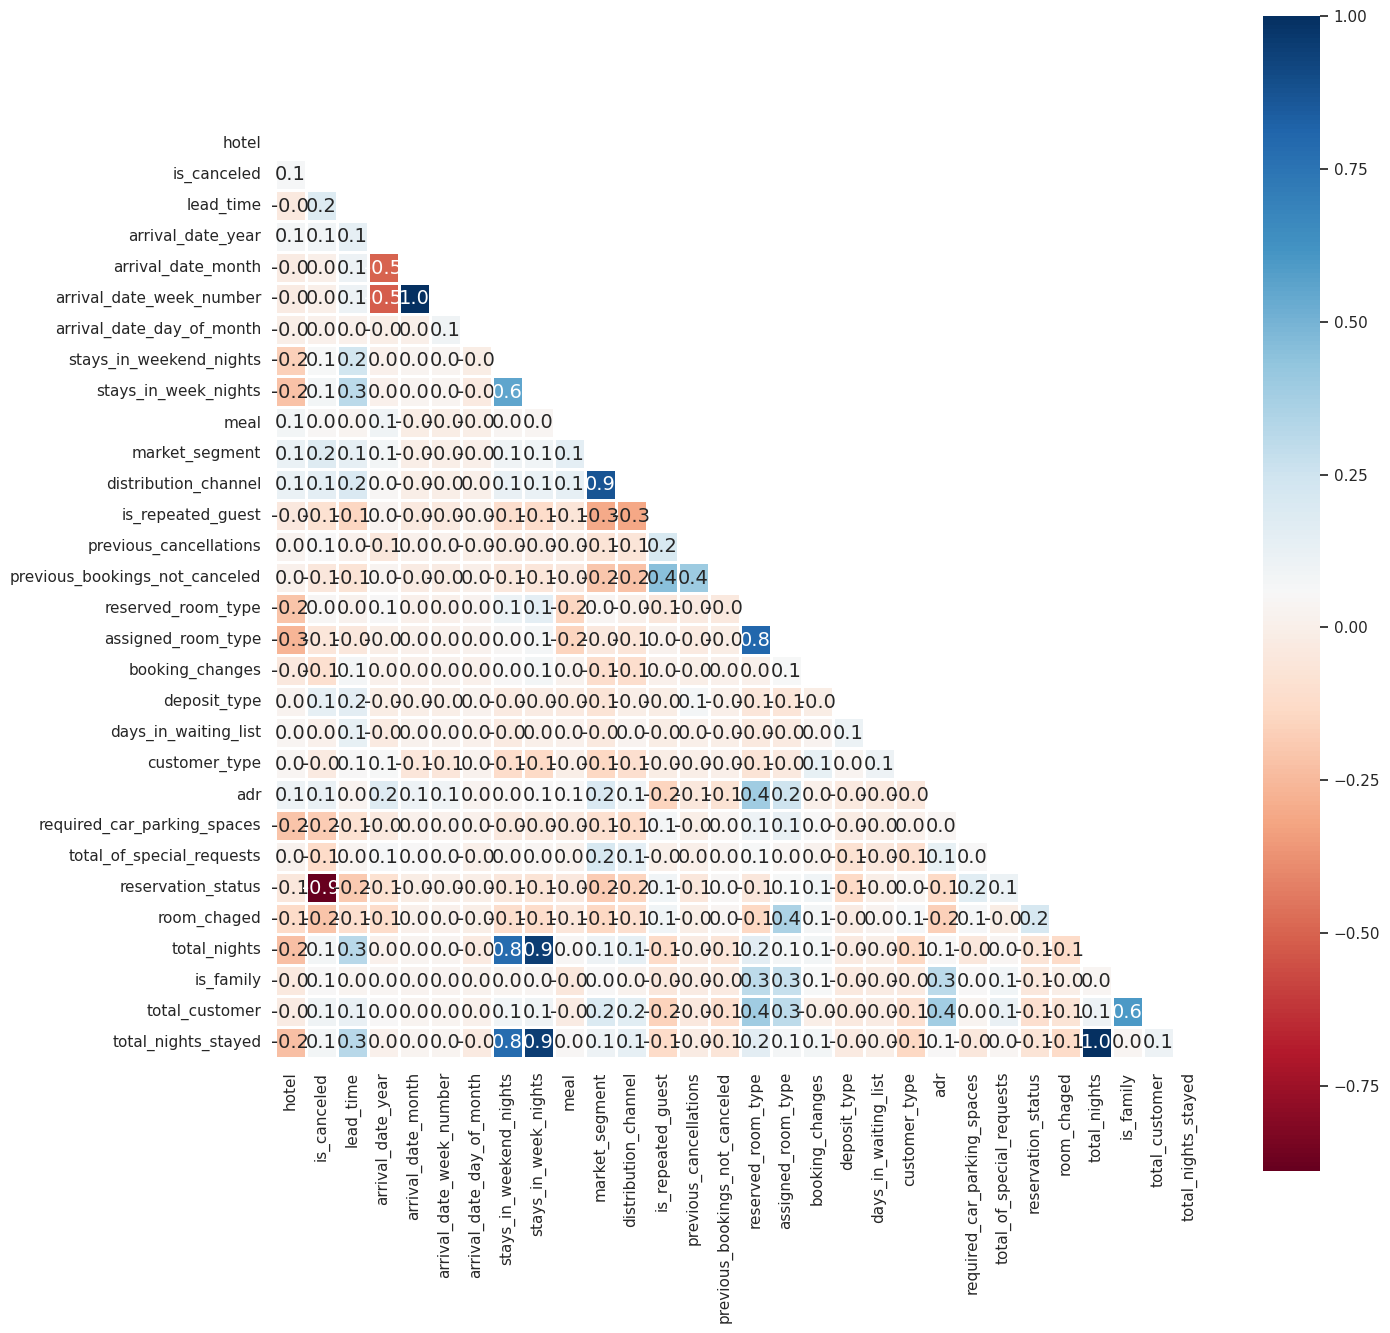

In [44]:
# correlation analysis (Heat map)
plt.figure(figsize = (15,15)) 
correlation_df = cor_df[cor_df.columns].corr()
mask = np.triu(correlation_df) 
sns.heatmap(correlation_df,mask = mask,cmap='RdBu',annot=True,square = True,fmt='.1f',linewidths = 1)  
plt.savefig("heatmap.png",dpi=300)

In [45]:
# Compute pairwise correlation of columns ('is_canceled' vs each column).
# Get sorted correlation series of is_canceled column
correlation_df_cancellation_sorted = correlation_df['is_canceled'].sort_values()
correlation_df_cancellation_sorted

reservation_status               -0.888852
room_chaged                      -0.213488
required_car_parking_spaces      -0.183751
total_of_special_requests        -0.121825
booking_changes                  -0.094074
is_repeated_guest                -0.090171
assigned_room_type               -0.061898
previous_bookings_not_canceled   -0.050567
customer_type                    -0.031004
arrival_date_week_number          0.000795
arrival_date_month                0.003040
days_in_waiting_list              0.004297
arrival_date_day_of_month         0.005227
meal                              0.044358
reserved_room_type                0.047189
is_family                         0.050000
previous_cancellations            0.050964
stays_in_weekend_nights           0.059596
hotel                             0.068895
stays_in_week_nights              0.082778
total_nights                      0.083866
total_nights_stayed               0.083866
arrival_date_year                 0.087745
total_custo

In [46]:
# Filter features with correlation's absolute value > 0.1
important_feature_series = correlation_df_cancellation_sorted[abs(correlation_df_cancellation_sorted) > 0.1]
target = 'is_canceled'
# 'reservation_status' as we can see in the sorted list above, it seems to be the most impactful feature. 
# With that information accuracy rate should be really high. 
# It's better to drop reservation_status column to see how other features can predict.
# Of course, we need to drop the 'is_canceled' column since it's our targeted analysis column.
# Since 'distribution_channel' and 'market_segment' have the samiliar meanings, we drop one.
#
important_features = important_feature_series.index.drop([target,'reservation_status','distribution_channel'])

important_features

Index(['room_chaged', 'required_car_parking_spaces',
       'total_of_special_requests', 'adr', 'deposit_type', 'market_segment',
       'lead_time'],
      dtype='object')

# 5. Model Evaluation

## Label Percentage Visualization

,0,1
is_canceled,72.406057,27.593943


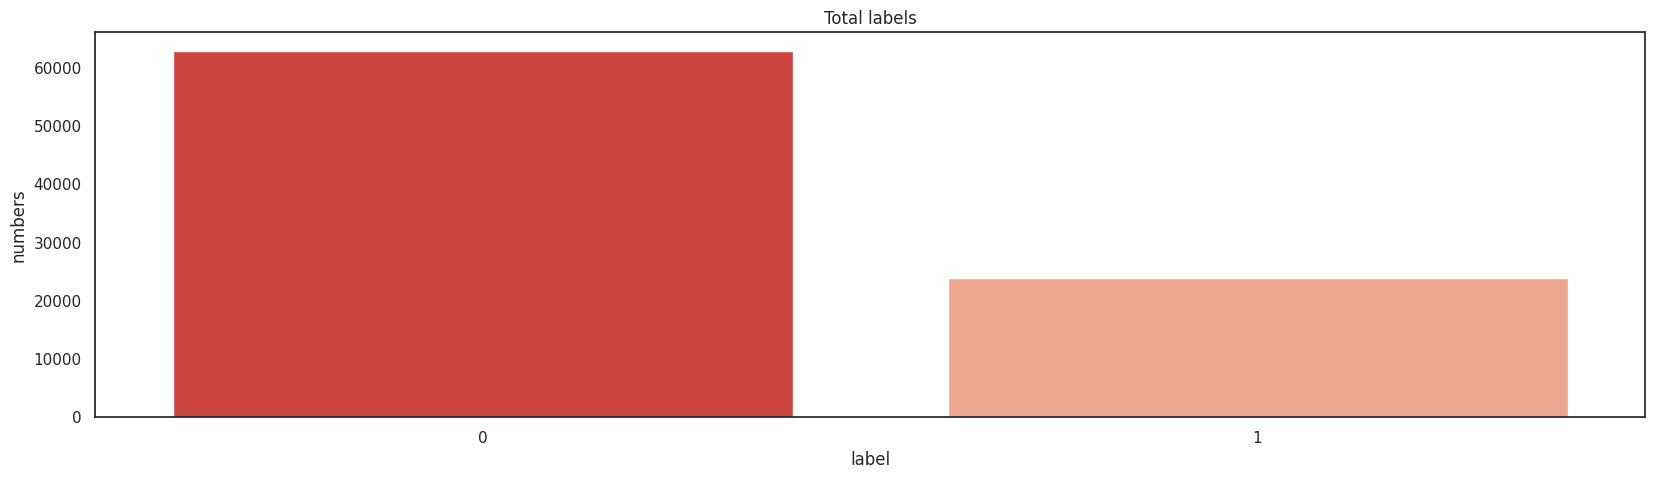

In [47]:
# Final dataframe with reduced dimensionality.
X = cor_df[important_features]
y = cor_df[target]

fig,ax = plt.subplots(figsize=(20,5))
# histogram of total label0 and label1
plt.title('Total labels')
plt.xlabel('label')
plt.ylabel('numbers')
sns.barplot(x = y.value_counts().index, y = y.value_counts().values, palette='Reds_r')
y_vc_percentage = y.value_counts()/len(y)*100
# Percentage of label0 and label1
display(y_vc_percentage.to_frame().T.style.background_gradient(cmap='Reds',axis=1))
plt.savefig("total_labels.png",dpi=300)

X.to_csv('./X.csv', index=False)
y.to_csv('./y.csv', index=False)

## Divide Train set and Test set

In [48]:
# Split the dataset into 80% training set and 20% testing set.
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

## No resampling model:

### ROC curve

In [49]:
# ROC

# We can use the functions to apply the models and roc curves to save space.
def get_roc_curve(y_test, y_prob):
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

### BalancedBaggingClassifier

Balanced Bagging Decision Tree Model:


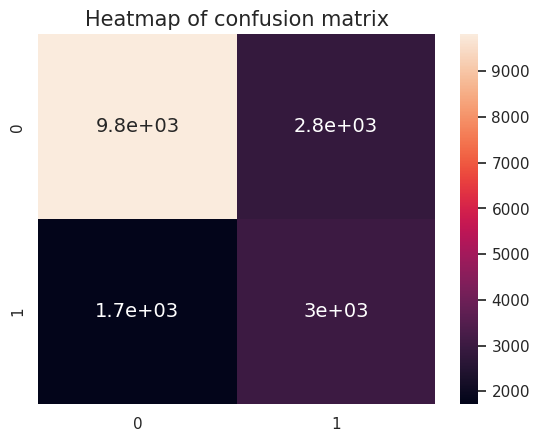

              precision    recall  f1-score   support

           0       0.85      0.78      0.81     12656
           1       0.51      0.63      0.57      4727

    accuracy                           0.74     17383
   macro avg       0.68      0.70      0.69     17383
weighted avg       0.76      0.74      0.74     17383



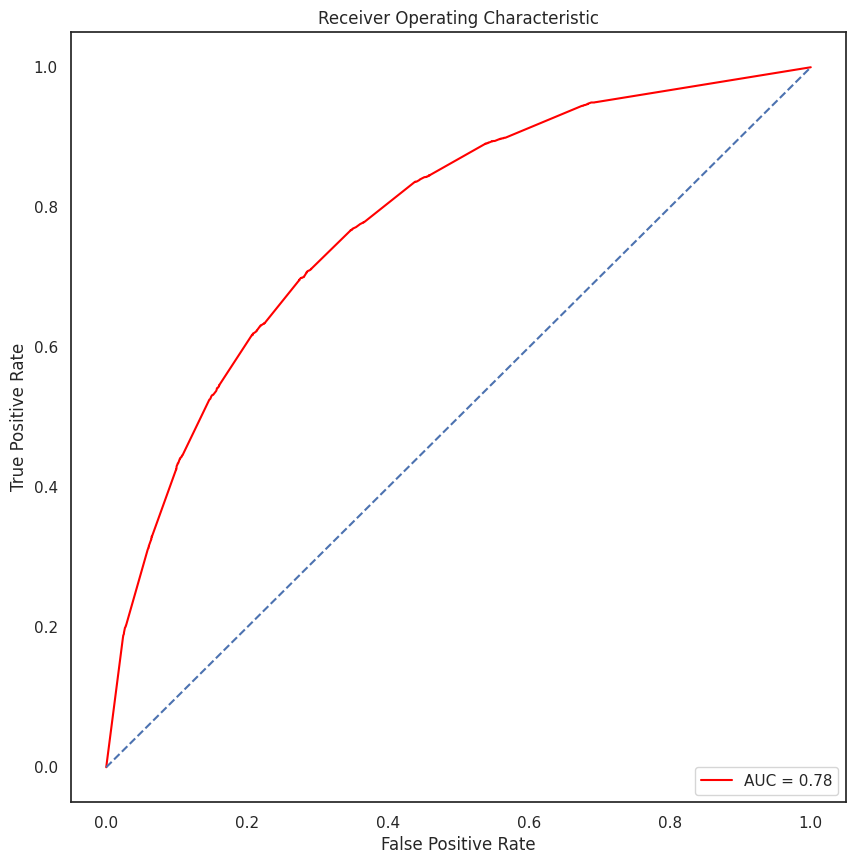

In [104]:
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.tree import DecisionTreeClassifier

# Create an object of the classifier.

clf = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),

                                sampling_strategy='auto',

                                replacement=False,

                                random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]

print("Balanced Bagging Decision Tree Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### BalancedRandomForestClassifier

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.

/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.

/usr/local/lib/python3.9/dist-packages/sklearn/utils/parallel.py:114: UserWarning:

`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the

Balanced Random Forest Model:


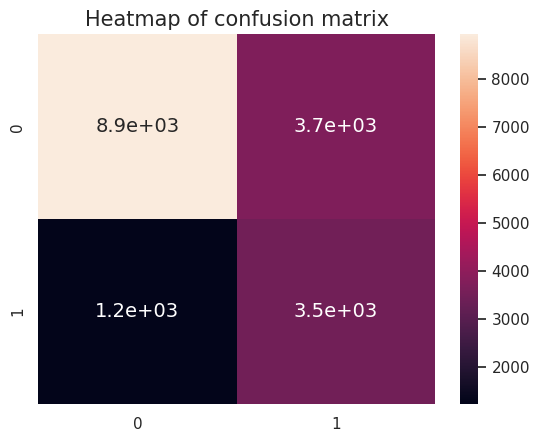

              precision    recall  f1-score   support

           0       0.88      0.71      0.78     12656
           1       0.48      0.74      0.58      4727

    accuracy                           0.71     17383
   macro avg       0.68      0.72      0.68     17383
weighted avg       0.77      0.71      0.73     17383



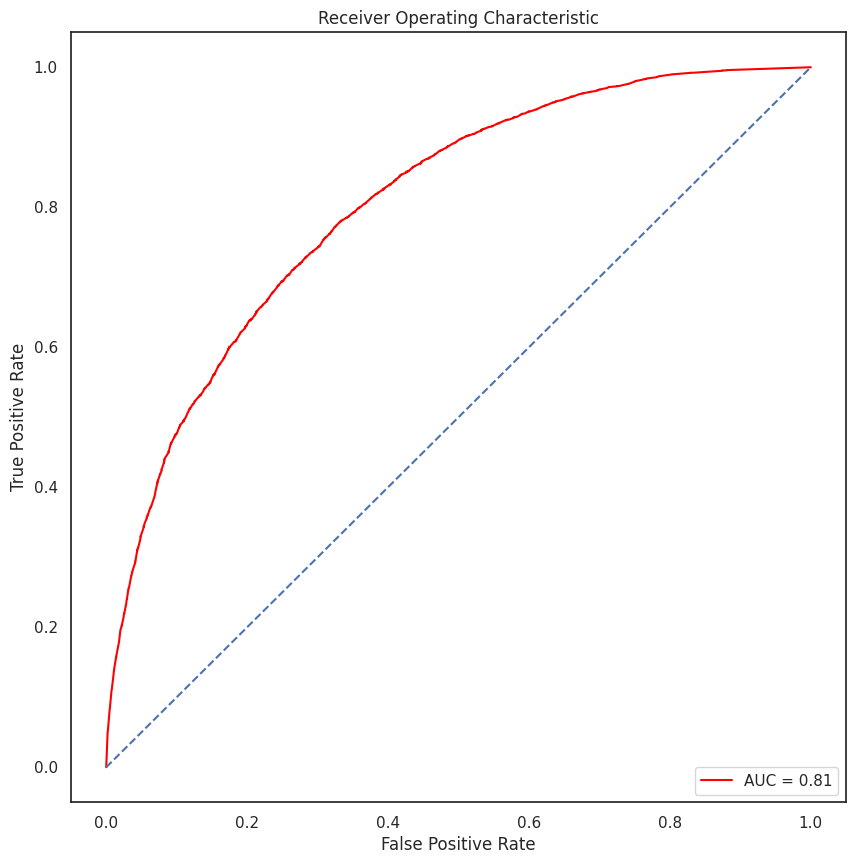

In [105]:
from imblearn.ensemble import BalancedRandomForestClassifier
# Create an object of the classifier.

clf = BalancedRandomForestClassifier(

                                sampling_strategy='auto',

                                replacement=False,

                                random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]

print("Balanced Random Forest Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### RUSBoostClassifier

RUSBoost Model:


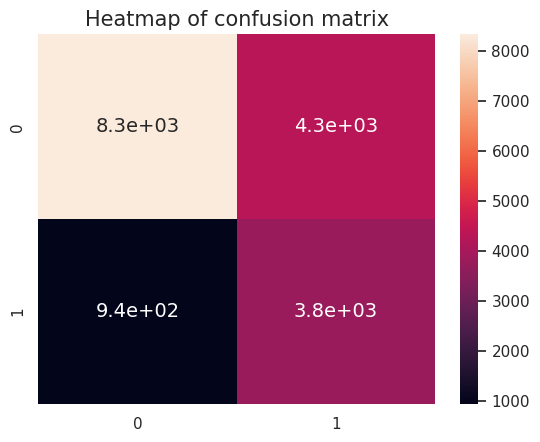

              precision    recall  f1-score   support

           0       0.90      0.66      0.76     12656
           1       0.47      0.80      0.59      4727

    accuracy                           0.70     17383
   macro avg       0.68      0.73      0.68     17383
weighted avg       0.78      0.70      0.71     17383



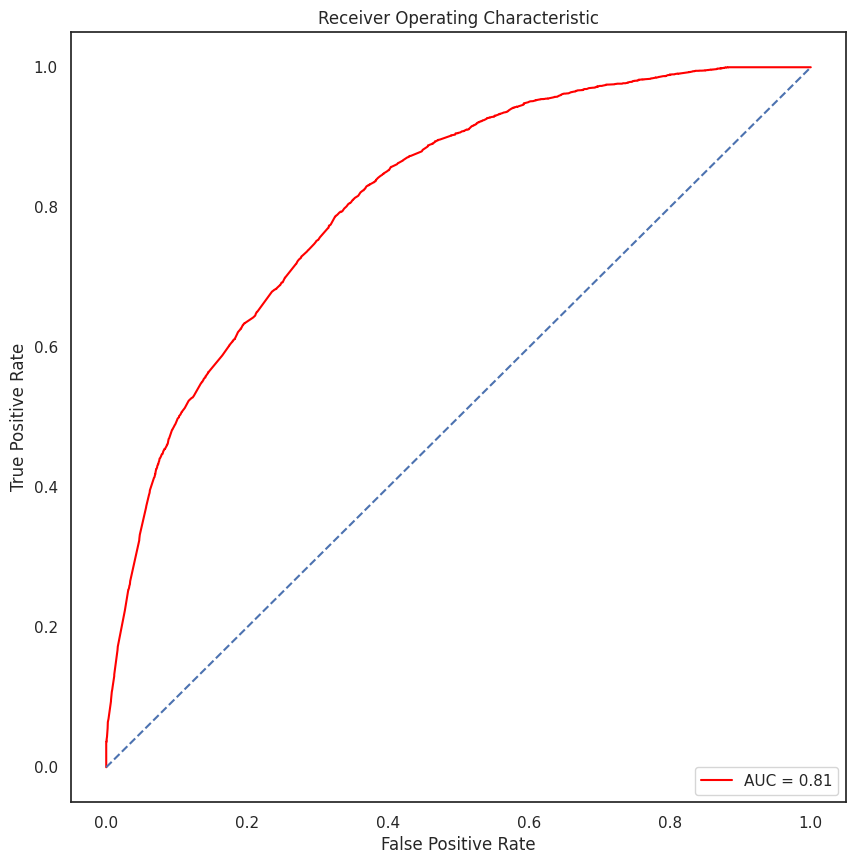

In [106]:
from imblearn.ensemble import RUSBoostClassifier
# Create an object of the classifier.

clf = RUSBoostClassifier(sampling_strategy='auto',replacement=False,random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]

print("RUSBoost Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### SVM

[LibSVM]SVM Model:


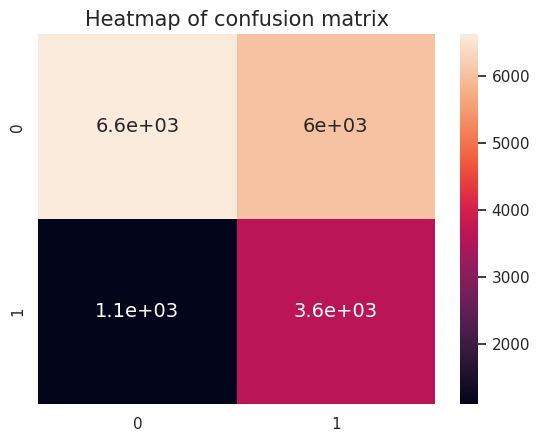

              precision    recall  f1-score   support

           0       0.86      0.52      0.65     12656
           1       0.38      0.77      0.50      4727

    accuracy                           0.59     17383
   macro avg       0.62      0.64      0.58     17383
weighted avg       0.73      0.59      0.61     17383



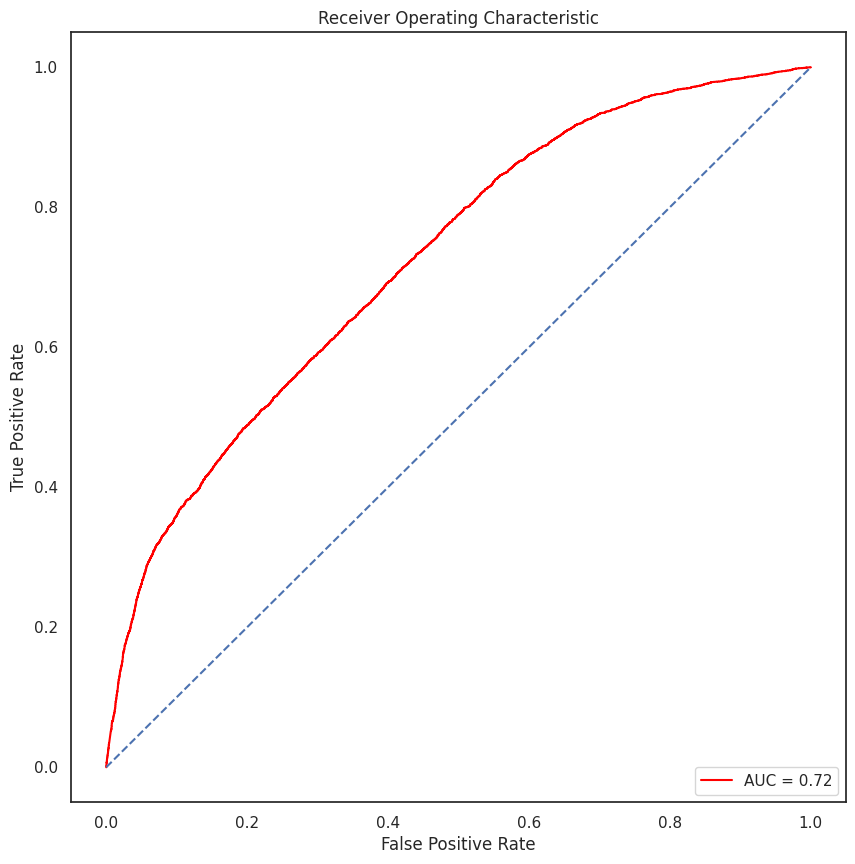

In [107]:
from sklearn.svm import SVC

clf = SVC(gamma='scale', class_weight='balanced', verbose=2, probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]

print("SVM Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### DecisionTree

Decision Tree Model:


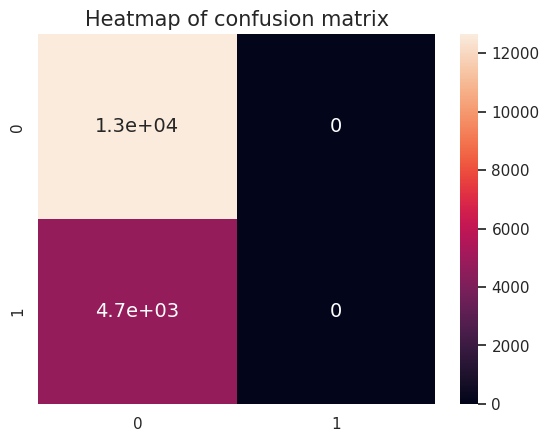

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.73      1.00      0.84     12656
           1       0.00      0.00      0.00      4727

    accuracy                           0.73     17383
   macro avg       0.36      0.50      0.42     17383
weighted avg       0.53      0.73      0.61     17383



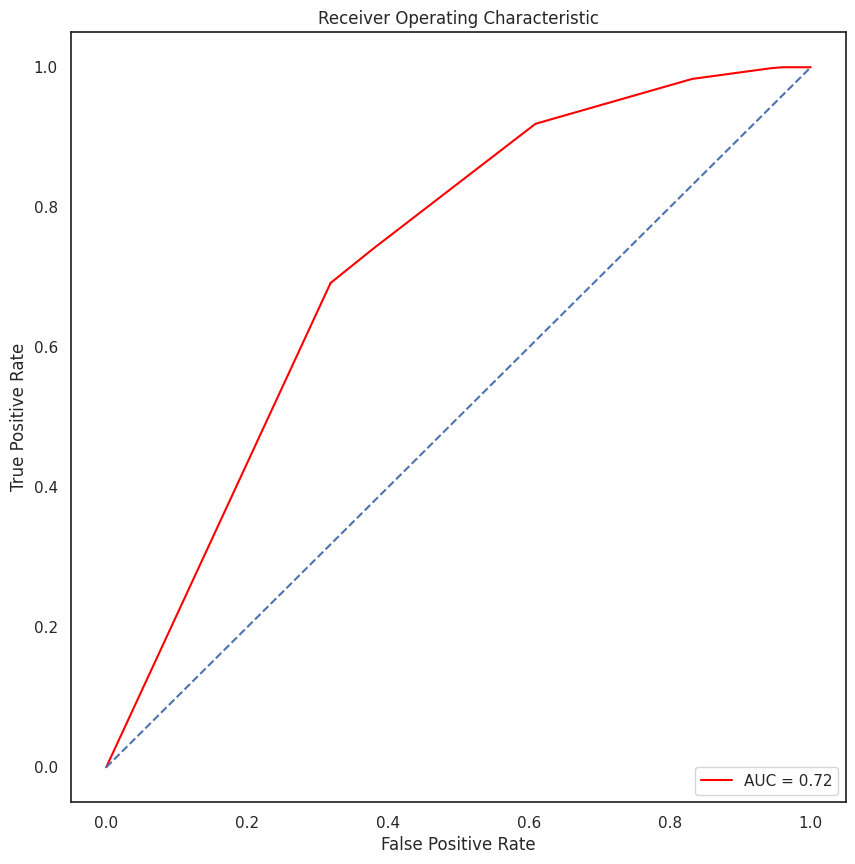

In [108]:
clf = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10, min_samples_leaf=13,
                       random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]

print("Decision Tree Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### LogisticRegression

Logistic Regression Model:


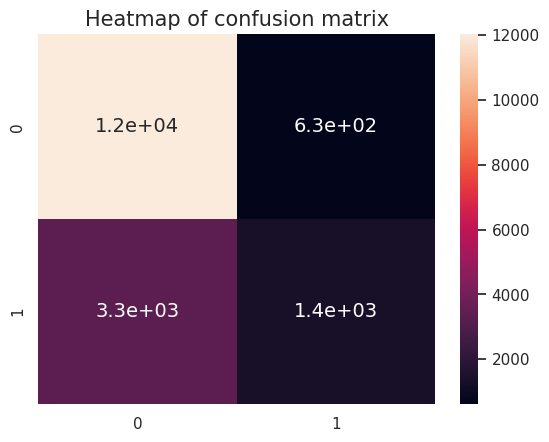

              precision    recall  f1-score   support

           0       0.78      0.95      0.86     12656
           1       0.69      0.29      0.41      4727

    accuracy                           0.77     17383
   macro avg       0.74      0.62      0.63     17383
weighted avg       0.76      0.77      0.74     17383



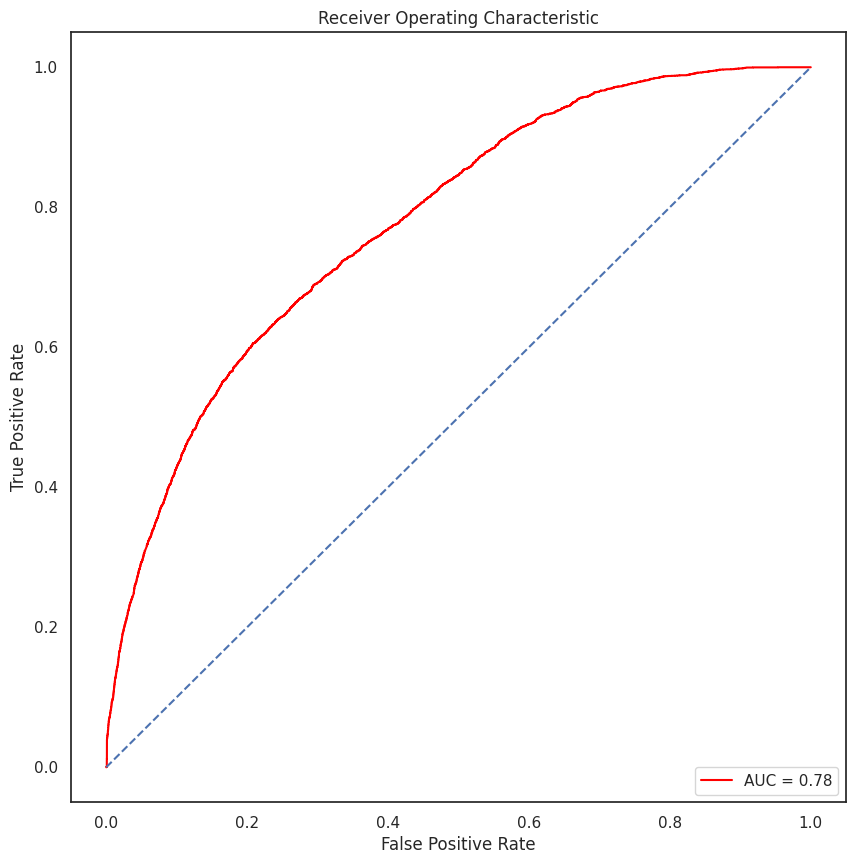

In [109]:
clf = LogisticRegression(random_state=0, n_jobs=-1, C=10, penalty='l2')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]
print("Logistic Regression Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### RandomForest

Random Forest Model:


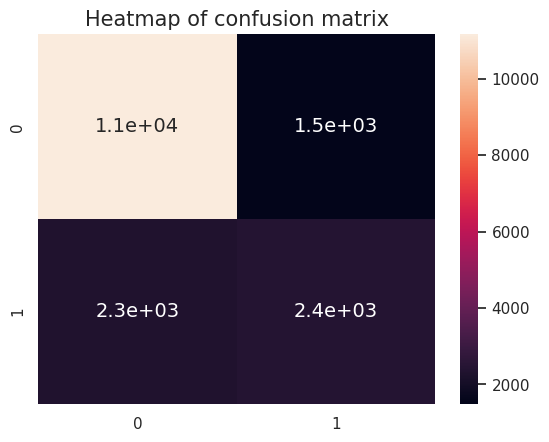

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     12656
           1       0.62      0.51      0.56      4727

    accuracy                           0.78     17383
   macro avg       0.72      0.70      0.71     17383
weighted avg       0.77      0.78      0.77     17383



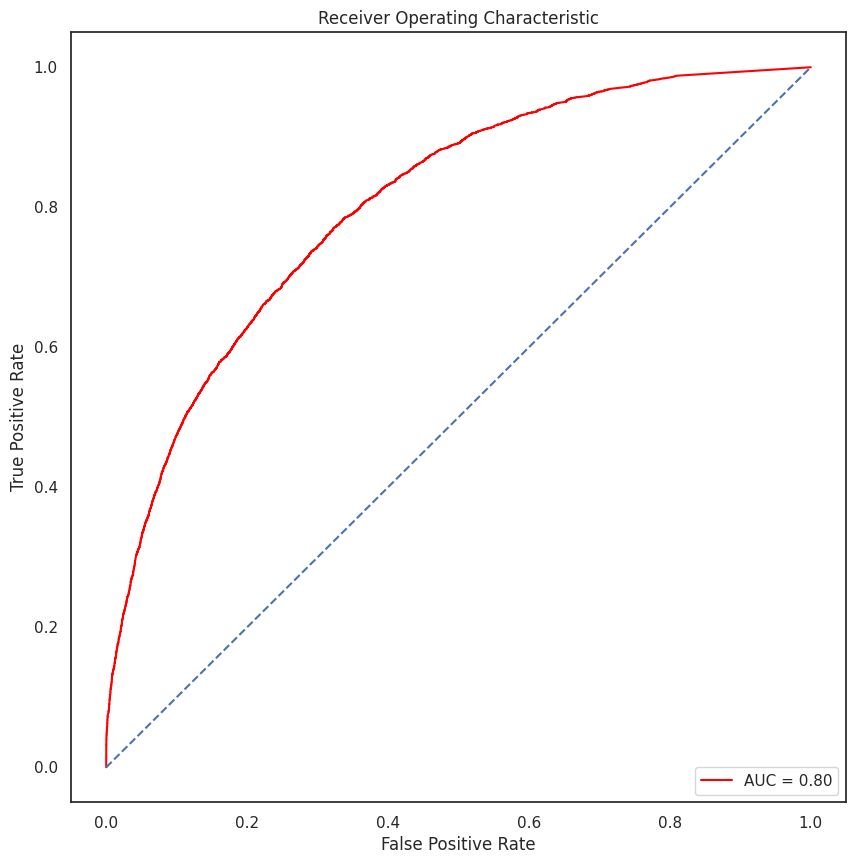

In [110]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=25, min_samples_split=2, n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]
print("Random Forest Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### Randomforest feature importance

Text(0.5, 0, 'Feature Importances (%)')

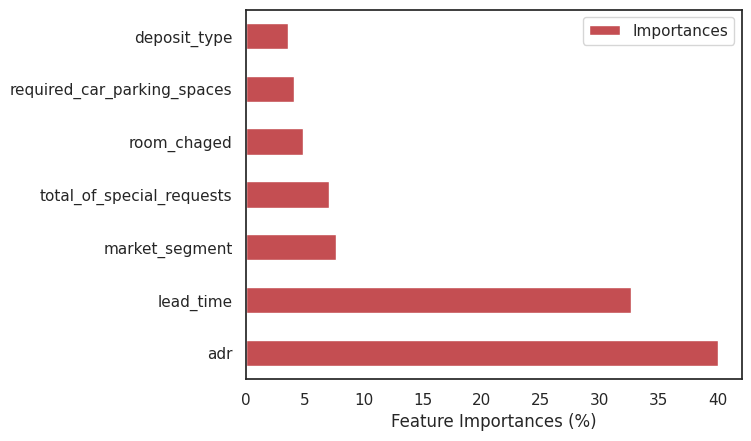

In [111]:
pd.DataFrame(data = clf.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False).plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

### XGBoost

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 1.5, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.4, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 0, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBoost Model:


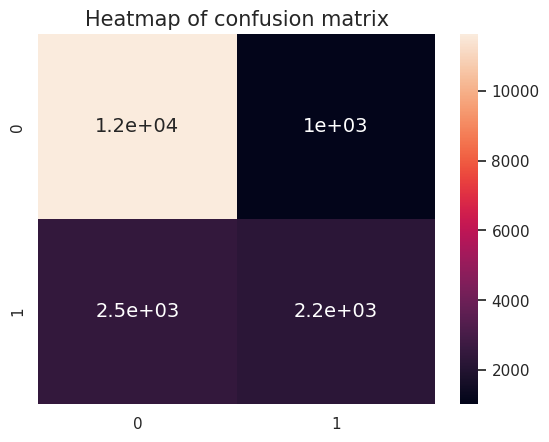

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     12656
           1       0.68      0.48      0.56      4727

    accuracy                           0.80     17383
   macro avg       0.75      0.70      0.71     17383
weighted avg       0.79      0.80      0.78     17383



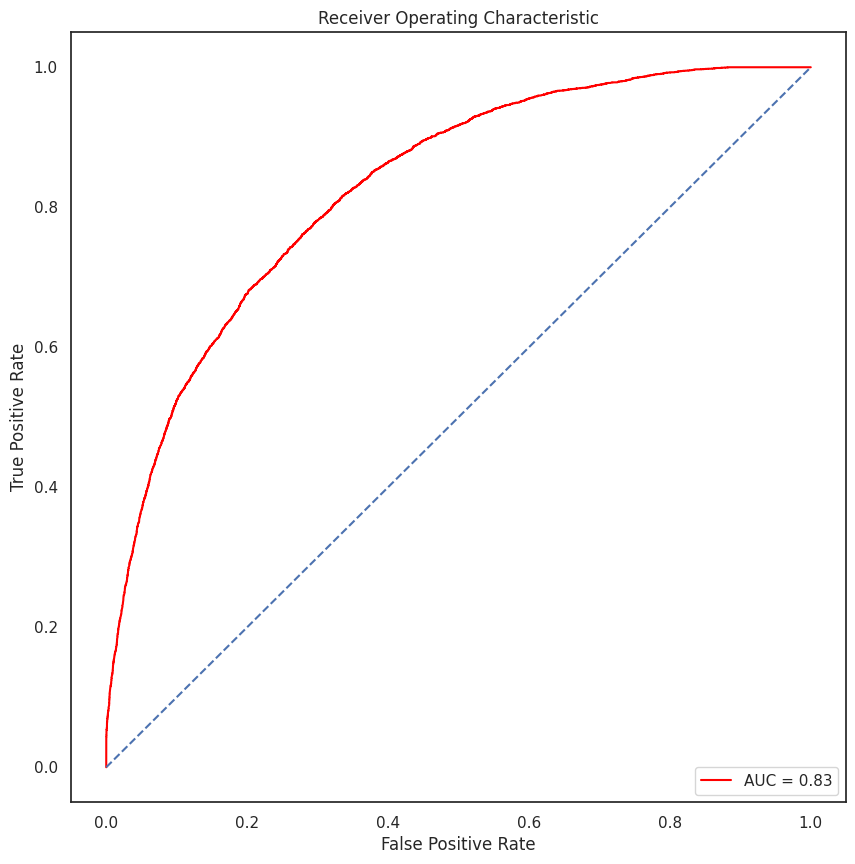

In [112]:
clf = XGBClassifier(random_state=0, n_jobs=-1,colsample_bytree= 1.0, gamma= 1.5, max_depth= 5, min_child_weight= 5, subsample= 0.8, learning_rate=0.4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]
print(clf.get_params())
print("XGBoost Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
get_roc_curve(y_test,y_pos_prob)

## Resampling: Oversampling and Undersampling

### SMOTETomek Oversampling and Undersampling

/usr/local/lib/python3.9/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning:

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.



,0,1
is_canceled,50.000000,50.000000


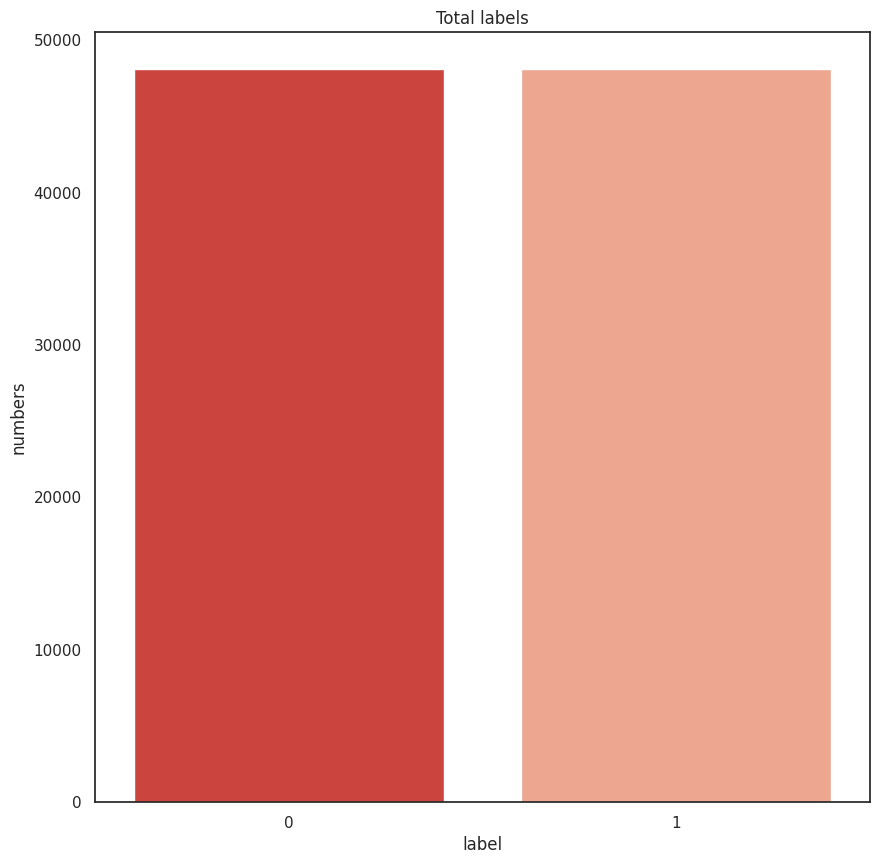

In [50]:
from imblearn.combine import SMOTETomek

# use SMOTETomek to oversample the minority class and undersample the majority class
smote_tomek = SMOTETomek(sampling_strategy='auto', n_jobs=-1)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)
fig,ax = plt.subplots(figsize=(10,10))
# histogram of total label0 and label1
plt.title('Total labels')
plt.xlabel('label')
plt.ylabel('numbers')
sns.barplot(x = y_train.value_counts().index, y = y_train.value_counts().values, palette='Reds_r')
y_vc_percentage = y_train.value_counts()/len(y_train)*100

# Percentage of label0 and label1
display(y_vc_percentage.to_frame().T.style.background_gradient(cmap='Reds',axis=1))

### DecisionTree

Decision Tree Model:


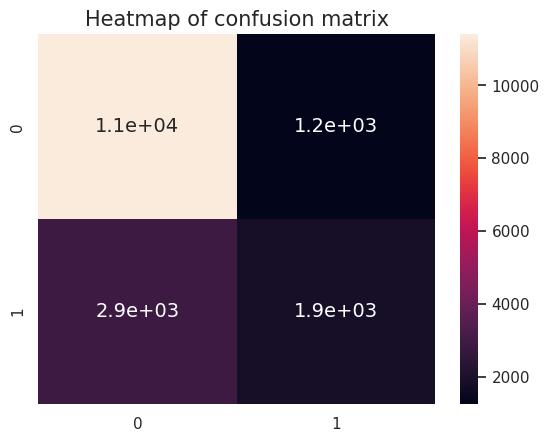

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     12656
           1       0.60      0.39      0.47      4727

    accuracy                           0.76     17383
   macro avg       0.70      0.65      0.66     17383
weighted avg       0.74      0.76      0.75     17383



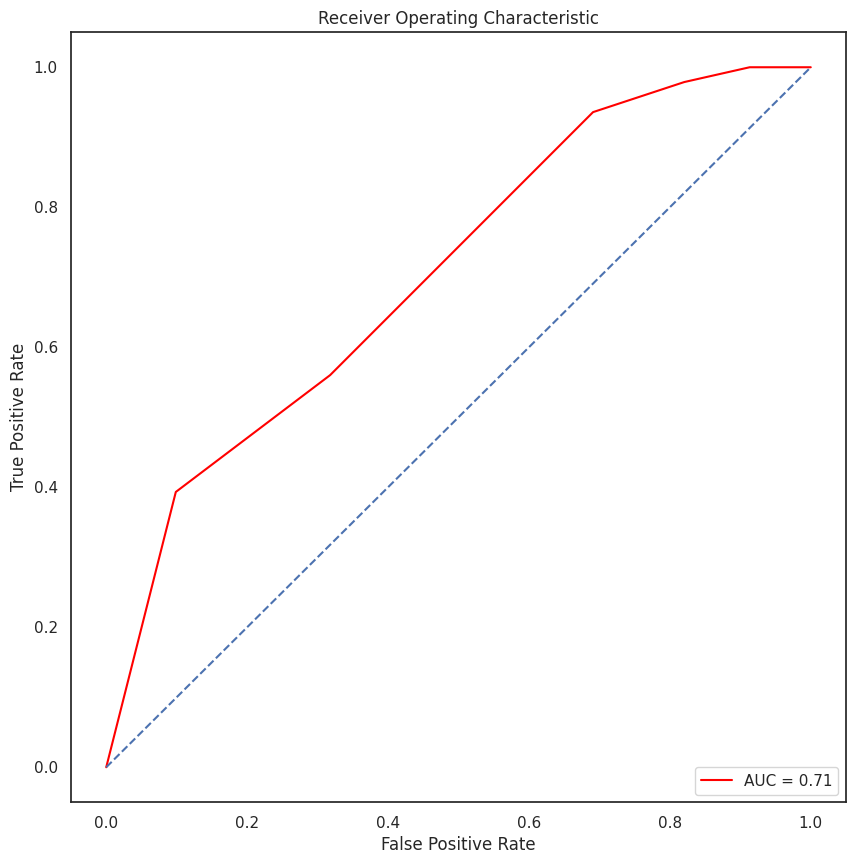

In [51]:
clf = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10, min_samples_leaf=13,
                       random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]

print("Decision Tree Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### LogisticRegression

Logistic Regression Model:


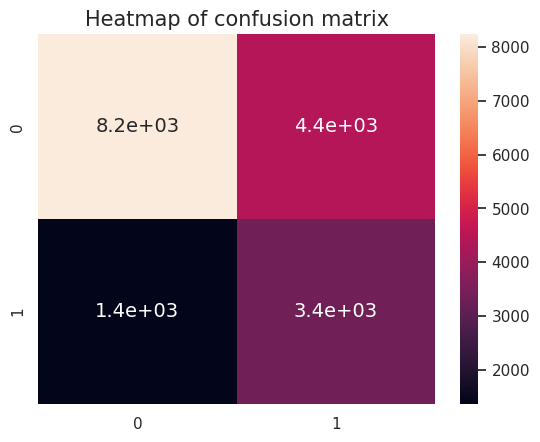

              precision    recall  f1-score   support

           0       0.86      0.65      0.74     12656
           1       0.43      0.71      0.54      4727

    accuracy                           0.67     17383
   macro avg       0.64      0.68      0.64     17383
weighted avg       0.74      0.67      0.69     17383



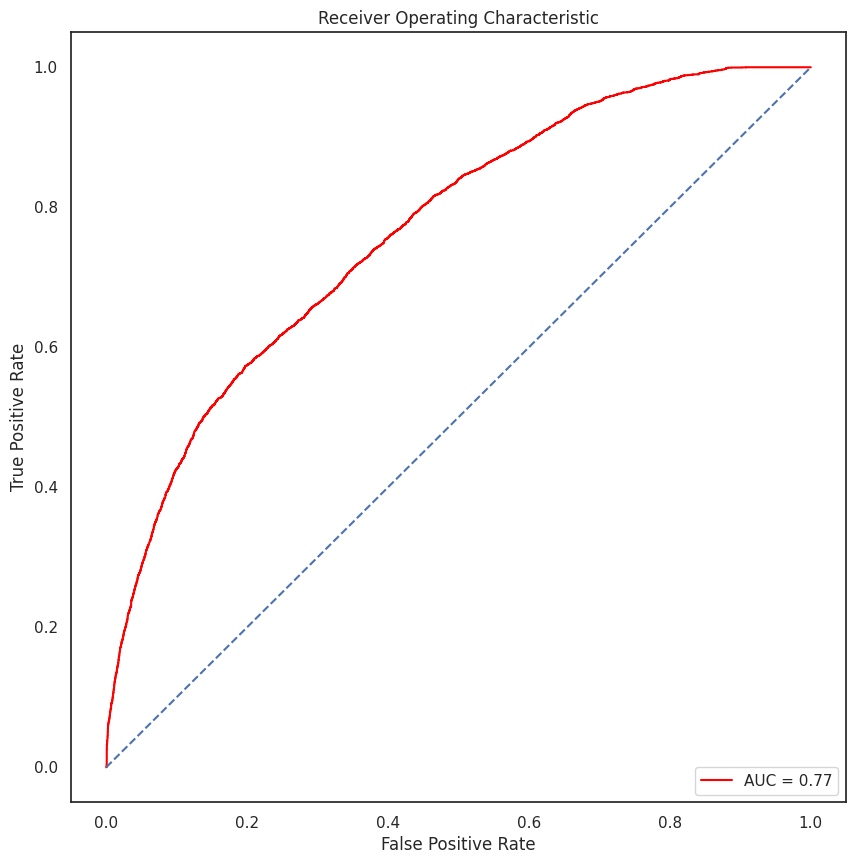

In [52]:
clf = LogisticRegression(random_state=0, n_jobs=-1, C=10, penalty='l2')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]
print("Logistic Regression Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### RandomForest

Random Forest Model:


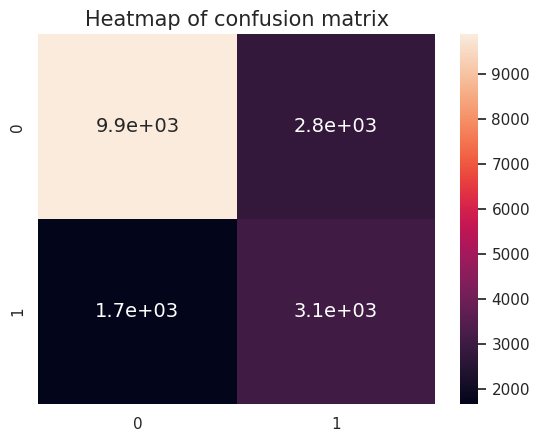

              precision    recall  f1-score   support

           0       0.86      0.78      0.82     12656
           1       0.52      0.65      0.58      4727

    accuracy                           0.74     17383
   macro avg       0.69      0.71      0.70     17383
weighted avg       0.77      0.74      0.75     17383



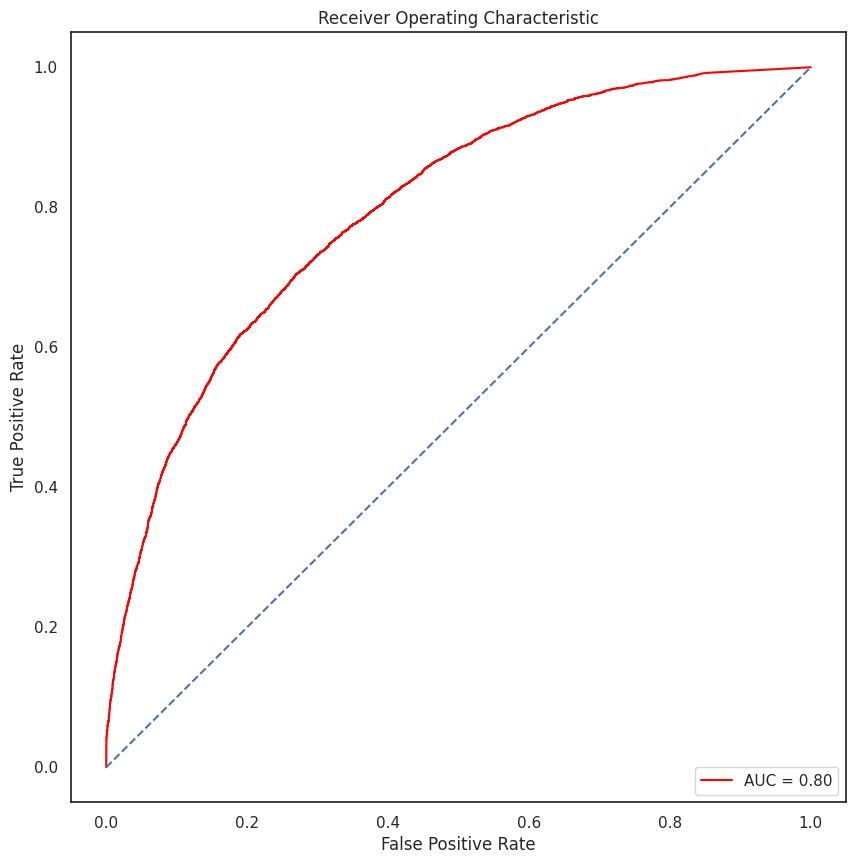

In [53]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=25, min_samples_split=4, n_estimators=110)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]
print("Random Forest Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
#print("Cross-validation F1-score: " , cross_val_score(clf, X, y, cv=10, scoring='f1').mean())
get_roc_curve(y_test,y_pos_prob)

### Random forest feature importance

Text(0.5, 0, 'Feature Importances (%)')

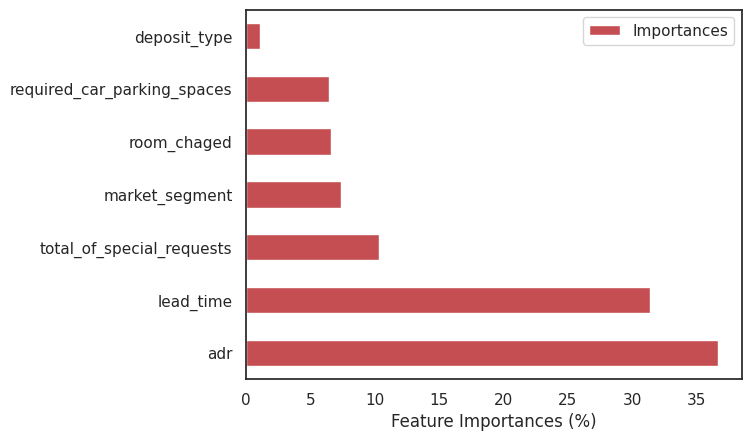

In [54]:
pd.DataFrame(data = clf.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False).plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

### XGBoost

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 1.5, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.4, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 0, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBoost Model:


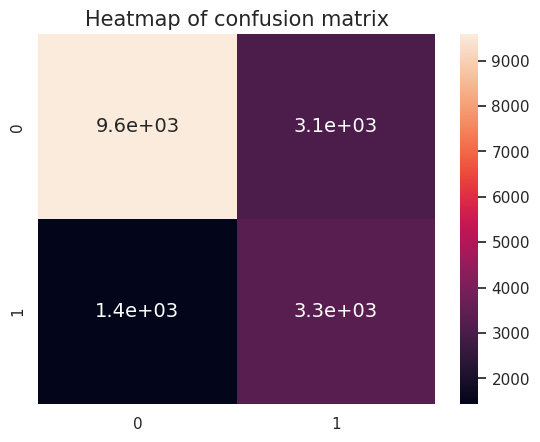

              precision    recall  f1-score   support

           0       0.87      0.76      0.81     12656
           1       0.52      0.70      0.59      4727

    accuracy                           0.74     17383
   macro avg       0.69      0.73      0.70     17383
weighted avg       0.77      0.74      0.75     17383



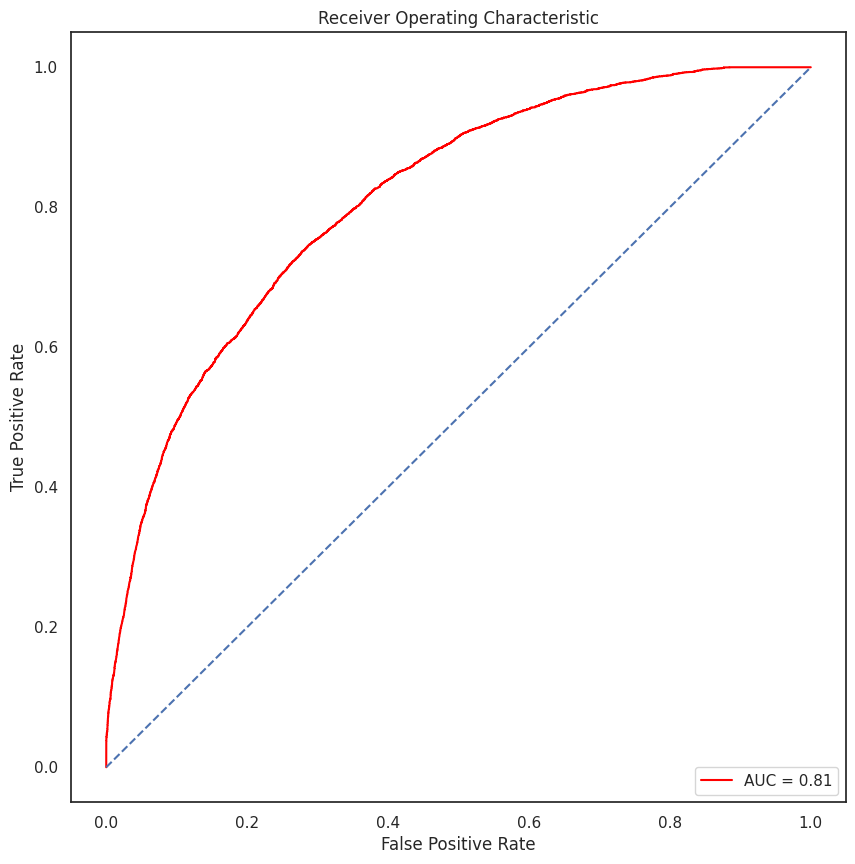

In [55]:
clf = XGBClassifier(random_state=0, n_jobs=-1,colsample_bytree= 1.0, gamma= 1.5, max_depth= 5, min_child_weight= 5, subsample= 0.8, learning_rate=0.4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]
print(clf.get_params())
print("XGBoost Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
get_roc_curve(y_test,y_pos_prob)

### SVM

[LibSVM]SVM Model:


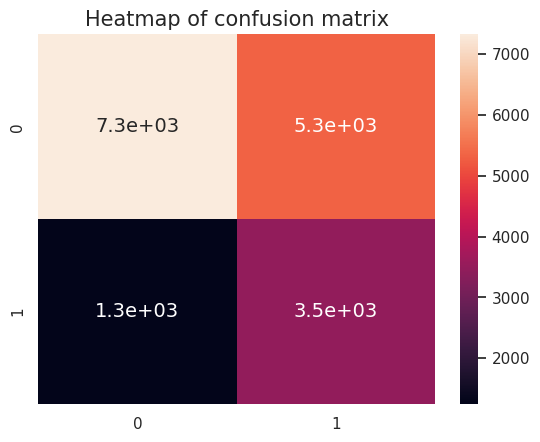

              precision    recall  f1-score   support

           0       0.85      0.58      0.69     12656
           1       0.39      0.74      0.51      4727

    accuracy                           0.62     17383
   macro avg       0.62      0.66      0.60     17383
weighted avg       0.73      0.62      0.64     17383



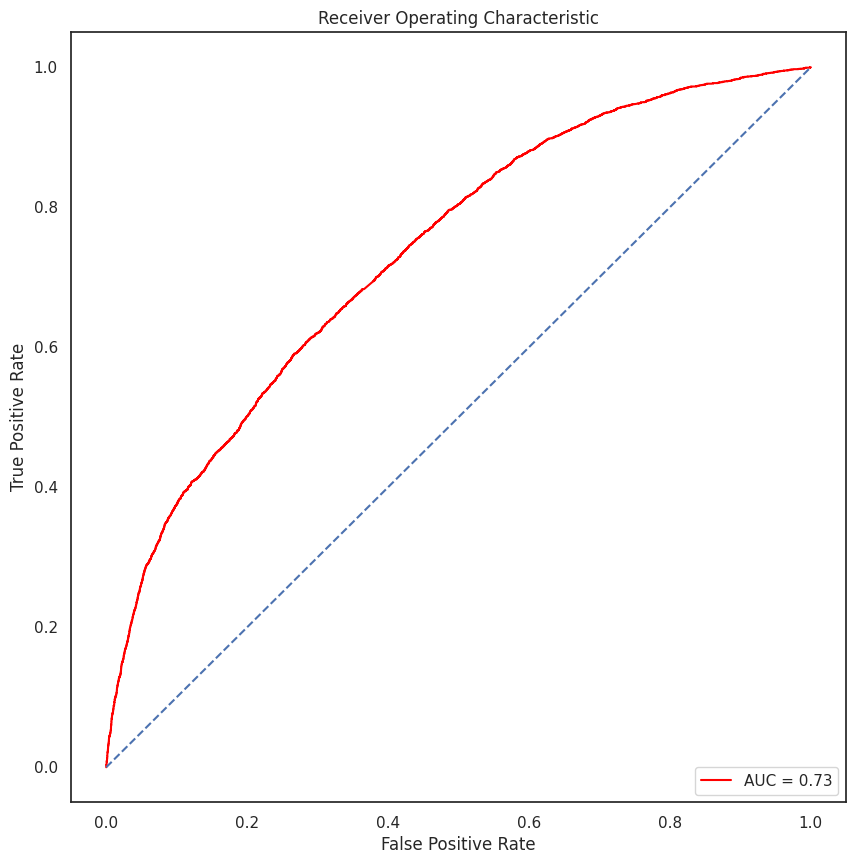

In [56]:
from sklearn.svm import SVC

clf = SVC(gamma='scale', class_weight='balanced', verbose=2, probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pos_prob = clf.predict_proba(X_test)[:,1]

print("SVM Model:")
cm = confusion_matrix(y_test, y_pred)
plt.title("Heatmap of confusion matrix", fontsize = 15)
sns.heatmap(cm,annot=True)
plt.show()
print(classification_report(y_test,y_pred))
get_roc_curve(y_test,y_pos_prob)

#Tuning Hyper-parameters

## Decision Tree

In [57]:
from sklearn.model_selection import GridSearchCV

param_dict = {
    'criterion': ['gini','entropy'], # gini
    'max_depth' : [3,5,8], # 9
    'min_samples_leaf': range(13,15,18),
    'max_leaf_nodes': range(10,101,100)
}
clf = DecisionTreeClassifier(random_state=0)
grid_search_cv = GridSearchCV(clf, param_dict, verbose=1, cv=3, scoring='recall', n_jobs=-1)
grid_search_cv.fit(X_train, y_train)
print(f"Best Score:{grid_search_cv.best_score_}")
print(f"Best Parameters:{grid_search_cv.best_params_}")
print(grid_search_cv.best_estimator_)
# f1 Best Parameters:{'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 90, 'min_samples_leaf': 10}
# precision Best Parameters:{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 90, 'min_samples_leaf': 18}

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Score:0.766036204542094
Best Parameters:{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 13}
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=10,
                       min_samples_leaf=13, random_state=0)


## Logistic Regression

In [58]:
param_dict = {'C': [0.1, 1, 10,20,30,40], 'penalty': ['l2']}
clf = LogisticRegression(random_state=0, n_jobs=-1)
grid_search_cv = GridSearchCV(clf, param_dict, verbose=1, cv=3, scoring='recall', n_jobs=-1)
grid_search_cv.fit(X_train, y_train)
print(f"Best Score:{grid_search_cv.best_score_}")
print(f"Best parameters:{grid_search_cv.best_params_}")
# Best parameters:{'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Score:0.7672196667841455
Best parameters:{'C': 20, 'penalty': 'l2'}


## Random Forest

In [ ]:
param_dict = {
    "max_depth": [5,10,15,20,25],
    "n_estimators": [100,110,120],
    "min_samples_split": [2,4,6,8,10]
}
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_search_cv = GridSearchCV(clf, param_dict, verbose=1, cv=3, scoring='recall', n_jobs=-1)
grid_search_cv.fit(X_train, y_train)
print(f"Best Score:{grid_search_cv.best_score_}")
print(f"Best parameters:{grid_search_cv.best_params_}")
# Best parameters:{'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 3 folds for each of 75 candidates, totalling 225 fits


## XGBoost

In [ ]:
# # Tuning the parameters by using GridCV
param_dict = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate':[0.01,0.1,0.2,0.3,0.4]
        }
clf = XGBClassifier(random_state=0)
grid_search_cv = GridSearchCV(clf, param_dict, verbose=3, cv=3, n_jobs=-1, scoring='recall')
grid_search_cv.fit(X_train, y_train)
print(f"Best Score:{grid_search_cv.best_score_}")
print(f"Best parameters:{grid_search_cv.best_params_}")
# Best parameters:{'colsample_bytree': 1.0, 'gamma': 1.5, 'learning_rate': 0.4, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}